In [1]:
import pandas as pd

In [2]:
df_surface_flow = pd.read_csv("surface_flow.csv")

In [3]:
df_surface_flow.head(200)

,PointID,x,y,Density,Momentum_x,Momentum_y,Energy,Nu_Tilde,Pressure,Temperature,Mach,Pressure_Coefficient,Laminar_Viscosity,Skin_Friction_Coefficient_x,Skin_Friction_Coefficient_y,Heat_Flux,Y_Plus,Eddy_Viscosity
0,25,0.985397,0.000966,0.465772,0.0,0.0,105948.138328,0.0,42379.255331,316.964100,0.0,0.249552,0.000019,0.002531,-0.000121,-297.574044,2.402825,0.0
1,51,0.969573,0.001624,0.471040,0.0,0.0,107177.736339,0.0,42871.094536,317.057069,0.0,0.283645,0.000019,0.001995,-0.000062,-128.009161,2.144116,0.0
2,77,0.952680,0.001984,0.475066,0.0,0.0,108128.362592,0.0,43251.345037,317.158299,0.0,0.310004,0.000019,0.001705,-0.000017,-73.866300,1.989597,0.0
3,103,0.934996,0.001963,0.476774,0.0,0.0,108538.223261,0.0,43415.289305,317.220200,0.0,0.321368,0.000019,0.001537,0.000023,-52.055137,1.891988,0.0
4,129,0.916822,0.001448,0.476953,0.0,0.0,108587.622855,0.0,43435.049142,317.245060,0.0,0.322738,0.000019,0.001444,0.000057,-43.289854,1.834633,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,4887,0.964163,0.007379,0.443931,0.0,0.0,100986.103840,0.0,40394.441536,316.983615,0.0,0.111968,0.000019,0.000351,-0.000070,20.496121,0.881181,0.0
188,4913,0.973876,0.005474,0.446333,0.0,0.0,101548.690401,0.0,40619.476160,317.034176,0.0,0.127567,0.000019,0.000322,-0.000063,19.360653,0.844552,0.0
189,4939,0.983087,0.003667,0.448676,0.0,0.0,102090.781829,0.0,40836.312732,317.061714,0.0,0.142598,0.000019,0.000351,-0.000069,16.359717,0.883830,0.0
190,4965,0.991850,0.001914,0.450185,0.0,0.0,102424.032246,0.0,40969.612898,317.030480,0.0,0.151838,0.000019,0.000514,-0.000106,5.378898,1.074031,0.0


<AxesSubplot:>

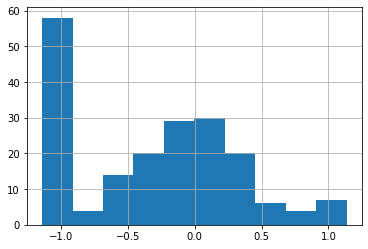

In [4]:
df_surface_flow["Pressure_Coefficient"].hist()

In [2]:
import re
import numpy as np

In [3]:
re_param_int = re.compile(r"([A-Z_]+)\s*=\s*\d+")
re_param_text = re.compile(r"([A-Z_]+)\s*=\s*\w+")

In [7]:
f = open("mesh_RAE2822_turb_deform.su2")
su2_lines = f.readlines()
f.close()

In [8]:
param, value = None, None
line_buffer = []
marker_tag = None

df_elems = pd.DataFrame(columns=["type", "nid1", "nid2", "nid3", "nid4", "eid"])
df_nodes = pd.DataFrame(columns=["x", "y", "nid"])
df_marker = pd.DataFrame(columns=["type", "nid1", "nid2", "tag"])

def proc_buffer(param, value, line_buffer):
    global df_elems, df_nodes,df_marker
    print("processing", param, len(line_buffer), value)
    if param == "NELEM":
        return
        #df_elems.append([l.split() for l in line_buffer])
        #print([l.split() for l in line_buffer])
        
        df_elems = pd.DataFrame(columns=["type", "nid1", "nid2", "nid3", "eid"], data=[l for l in line_buffer])
        df_elems = df_elems.astype(int).set_index("eid")
    elif param == "NPOIN":
        #if = lambda l: double(l[0])
        print(line_buffer[:3])
        df_nodes = pd.DataFrame(columns=df_nodes.columns, data=line_buffer)
        df_nodes[["x", "y"]] = df_nodes[["x", "y"]].astype("double")
        df_nodes[["nid"]] = df_nodes[["nid"]].astype("int")
        df_nodes = df_nodes.set_index("nid")
    elif param == "MARKER_ELEMS":        
        df_marker_new = pd.DataFrame(columns=["type", "nid1", "nid2"], data=line_buffer).astype(int)
        df_marker_new["tag"] = marker_tag
        df_marker = df_marker.append(df_marker_new)
    
    line_buffer = []

for line in su2_lines:
    #if re_param_int.match(line):
    #    proc_buffer(param, value, line_buffer)
    #    line_buffer = []
    #    param, value = [s.strip() for s in line.split("=", 1)] 
    #    value = int(value)
        
    if re_param_text.match(line):
        proc_buffer(param, value, line_buffer)
        line_buffer = []
        
        param, value = [s.strip() for s in line.split("=", 1)]
        if param == "MARKER_TAG":
            marker_tag = value
    else:
        line_buffer.append(line.split())

proc_buffer(param, value, line_buffer)

processing None 0 None
processing NDIME 0 2
processing NELEM 22842 22842
processing NPOIN 13937 13937
[['9.999995198807280e-01', '1.588015321776636e-04', '0'], ['9.999990392916476e-01', '1.467866113624814e-04', '1'], ['9.999984981025273e-01', '1.325339395063598e-04', '2']]
processing NMARK 0 2
processing MARKER_TAG 0 AIRFOIL
processing MARKER_ELEMS 192 192
processing MARKER_TAG 0 FARFIELD
processing MARKER_ELEMS 40 40


In [9]:
for i, row in df_marker.iterrows():
    print(i, row)

0 type          3
nid1       4965
nid2       4991
tag     AIRFOIL
Name: 0, dtype: object
1 type          3
nid1       4939
nid2       4965
tag     AIRFOIL
Name: 1, dtype: object
2 type          3
nid1       4913
nid2       4939
tag     AIRFOIL
Name: 2, dtype: object
3 type          3
nid1       4887
nid2       4913
tag     AIRFOIL
Name: 3, dtype: object
4 type          3
nid1       4861
nid2       4887
tag     AIRFOIL
Name: 4, dtype: object
5 type          3
nid1       4835
nid2       4861
tag     AIRFOIL
Name: 5, dtype: object
6 type          3
nid1       4809
nid2       4835
tag     AIRFOIL
Name: 6, dtype: object
7 type          3
nid1       4783
nid2       4809
tag     AIRFOIL
Name: 7, dtype: object
8 type          3
nid1       4757
nid2       4783
tag     AIRFOIL
Name: 8, dtype: object
9 type          3
nid1       4731
nid2       4757
tag     AIRFOIL
Name: 9, dtype: object
10 type          3
nid1       4705
nid2       4731
tag     AIRFOIL
Name: 10, dtype: object
11 type          3


Name: 110, dtype: object
111 type          3
nid1       2079
nid2       2105
tag     AIRFOIL
Name: 111, dtype: object
112 type          3
nid1       2053
nid2       2079
tag     AIRFOIL
Name: 112, dtype: object
113 type          3
nid1       2027
nid2       2053
tag     AIRFOIL
Name: 113, dtype: object
114 type          3
nid1       2001
nid2       2027
tag     AIRFOIL
Name: 114, dtype: object
115 type          3
nid1       1975
nid2       2001
tag     AIRFOIL
Name: 115, dtype: object
116 type          3
nid1       1949
nid2       1975
tag     AIRFOIL
Name: 116, dtype: object
117 type          3
nid1       1923
nid2       1949
tag     AIRFOIL
Name: 117, dtype: object
118 type          3
nid1       1897
nid2       1923
tag     AIRFOIL
Name: 118, dtype: object
119 type          3
nid1       1871
nid2       1897
tag     AIRFOIL
Name: 119, dtype: object
120 type          3
nid1       1845
nid2       1871
tag     AIRFOIL
Name: 120, dtype: object
121 type          3
nid1       1819
nid2     

Name: 30, dtype: object
31 type           3
nid1        5025
nid2        5026
tag     FARFIELD
Name: 31, dtype: object
32 type           3
nid1        5024
nid2        5025
tag     FARFIELD
Name: 32, dtype: object
33 type           3
nid1        5023
nid2        5024
tag     FARFIELD
Name: 33, dtype: object
34 type           3
nid1        5022
nid2        5023
tag     FARFIELD
Name: 34, dtype: object
35 type           3
nid1        5021
nid2        5022
tag     FARFIELD
Name: 35, dtype: object
36 type           3
nid1        5020
nid2        5021
tag     FARFIELD
Name: 36, dtype: object
37 type           3
nid1        5019
nid2        5020
tag     FARFIELD
Name: 37, dtype: object
38 type           3
nid1        5018
nid2        5019
tag     FARFIELD
Name: 38, dtype: object
39 type           3
nid1        5017
nid2        5018
tag     FARFIELD
Name: 39, dtype: object


In [10]:
df_marker[df_marker["tag"]=="AIRFOIL"]

,type,nid1,nid2,tag
0,3,4965,4991,AIRFOIL
1,3,4939,4965,AIRFOIL
2,3,4913,4939,AIRFOIL
3,3,4887,4913,AIRFOIL
4,3,4861,4887,AIRFOIL
...,...,...,...,...
187,3,103,129,AIRFOIL
188,3,77,103,AIRFOIL
189,3,51,77,AIRFOIL
190,3,25,51,AIRFOIL


In [11]:
airfoil_marker = df_marker[df_marker["tag"]=="AIRFOIL"]
airfoil_marker["nid1"].values, airfoil_marker["nid2"].values

(array([4965, 4939, 4913, 4887, 4861, 4835, 4809, 4783, 4757, 4731, 4705,
        4679, 4653, 4627, 4601, 4575, 4549, 4523, 4497, 4471, 4445, 4419,
        4393, 4367, 4341, 4315, 4289, 4263, 4237, 4211, 4185, 4159, 4133,
        4107, 4081, 4055, 4029, 4003, 3977, 3951, 3925, 3899, 3873, 3847,
        3821, 3795, 3769, 3743, 3717, 3691, 3665, 3639, 3613, 3587, 3561,
        3535, 3509, 3483, 3457, 3431, 3405, 3379, 3353, 3327, 3301, 3275,
        3249, 3223, 3197, 3171, 3145, 3119, 3093, 3067, 3041, 3015, 2989,
        2963, 2937, 2911, 2885, 2859, 2833, 2807, 2781, 2755, 2729, 2703,
        2677, 2651, 2625, 2599, 2573, 2547, 2521, 2495, 2469, 2443, 2417,
        2391, 2365, 2339, 2313, 2287, 2261, 2235, 2209, 2183, 2157, 2131,
        2105, 2079, 2053, 2027, 2001, 1975, 1949, 1923, 1897, 1871, 1845,
        1819, 1793, 1767, 1741, 1715, 1689, 1663, 1637, 1611, 1585, 1559,
        1533, 1507, 1481, 1455, 1429, 1403, 1377, 1351, 1325, 1299, 1273,
        1247, 1221, 1195, 1169, 1143, 

In [12]:
x1 = df_nodes.loc[airfoil_marker["nid1"]]["x"].values
x2 = df_nodes.loc[airfoil_marker["nid2"].values]["x"].values
y1 = df_nodes.loc[airfoil_marker["nid1"].values]["y"].values
y2 = df_nodes.loc[airfoil_marker["nid2"].values]["y"].values

In [13]:
for a,b,c,d in zip(x1, x2, y1, y2):
    print(a,b,c,d)

0.99185049533844 1.0 0.001914441721790363 0.000169999999343418
0.983087241649628 0.99185049533844 0.003666795341703698 0.001914441721790363
0.973875820636749 0.983087241649628 0.005473548558575582 0.003666795341703698
0.964163184165955 0.973875820636749 0.007379070294250087 0.005473548558575582
0.95406448841095 0.964163184165955 0.00943976808179185 0.007379070294250087
0.943587005138397 0.95406448841095 0.01163790562089603 0.00943976808179185
0.932719111442566 0.943587005138397 0.01391579724046739 0.01163790562089603
0.92144650220871 0.932719111442566 0.01620781924972028 0.01391579724046739
0.909807145595551 0.92144650220871 0.01847253520132013 0.01620781924972028
0.897873163223267 0.909807145595551 0.02069790300092629 0.01847253520132013
0.885585725307465 0.897873163223267 0.02286345093414164 0.02069790300092629
0.873027920722961 0.885585725307465 0.02499104691827159 0.02286345093414164
0.860195755958557 0.873027920722961 0.02708880125322366 0.02499104691827159
0.847066879272461 0.860

In [14]:
x1.argmin(), x1.argmax()

(107, 191)

In [15]:
x2.argmin(), x2.argmax()

(108, 0)

In [16]:
x1[107], y1[107]

(0.0, 0.0)

In [17]:
y1[130], y1[70]

(-0.0324255356776584, 0.04010666646184249)

In [31]:
import matplotlib.pyplot as plt

In [32]:
len(x1)

NameError: name 'x1' is not defined

In [33]:
#plt.plot(x1,y1, c=)

In [21]:
np.linspace(0, 1, 192).shape

(192,)

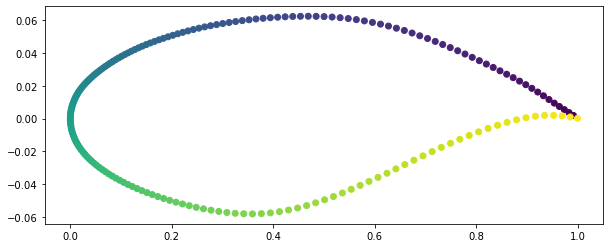

In [22]:
plt.figure(figsize=(10,4))
plt.scatter(x1,y1,c=np.linspace(0, 1, 192))


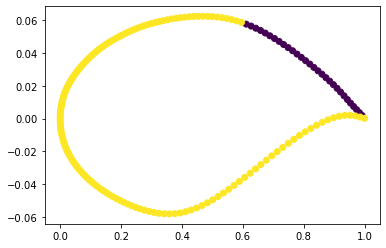

In [23]:
plt.scatter(x1,y1,c=[0]*30 + [1]*162)

In [24]:
plt.rcParams["image.cmap"]

'viridis'

In [4]:
import torch

In [26]:
torch.cuda.is_available()
torch.__version__

'1.6.0'

In [5]:
x = df_surface_flow["x"].values

NameError: name 'df_surface_flow' is not defined

In [6]:
np.stack(x[-10:].copy(), x.copy(), x[:10].copy())

NameError: name 'x' is not defined

In [ ]:
x_l = x[-10:].copy()

In [ ]:
x_r = x[:10].copy()

In [ ]:
x_input = np.hstack((x_l, x, x_r)).shape

In [ ]:
x_in = np.zeros((212,2)) 
x_in[10:-10,0] = df_surface_flow["x"].values
x_in[10:-10,1] = df_surface_flow["y"].values

In [29]:
x_in = np.zeros((212,2)) 
x_in[10:-10] = df_surface_flow[["x", "y"]].values
x_in[:10] = df_surface_flow[["x", "y"]].values[-10:]
x_in[-10:] = df_surface_flow[["x", "y"]].values[:10]

In [30]:
x_in[10:-10] = df_surface_flow[["PointID"]].values
x_in[:10] = df_surface_flow[["PointID"]].values[-10:]
x_in[-10:] = df_surface_flow[["PointID"]].values[:10]

In [31]:
x_in

array([[4757., 4757.],
       [4783., 4783.],
       [4809., 4809.],
       [4835., 4835.],
       [4861., 4861.],
       [4887., 4887.],
       [4913., 4913.],
       [4939., 4939.],
       [4965., 4965.],
       [4991., 4991.],
       [  25.,   25.],
       [  51.,   51.],
       [  77.,   77.],
       [ 103.,  103.],
       [ 129.,  129.],
       [ 155.,  155.],
       [ 181.,  181.],
       [ 207.,  207.],
       [ 233.,  233.],
       [ 259.,  259.],
       [ 285.,  285.],
       [ 311.,  311.],
       [ 337.,  337.],
       [ 363.,  363.],
       [ 389.,  389.],
       [ 415.,  415.],
       [ 441.,  441.],
       [ 467.,  467.],
       [ 493.,  493.],
       [ 519.,  519.],
       [ 545.,  545.],
       [ 571.,  571.],
       [ 597.,  597.],
       [ 623.,  623.],
       [ 649.,  649.],
       [ 675.,  675.],
       [ 701.,  701.],
       [ 727.,  727.],
       [ 753.,  753.],
       [ 779.,  779.],
       [ 805.,  805.],
       [ 831.,  831.],
       [ 857.,  857.],
       [ 88

In [32]:
df_surface_flow["PointID"].values

array([  25,   51,   77,  103,  129,  155,  181,  207,  233,  259,  285,
        311,  337,  363,  389,  415,  441,  467,  493,  519,  545,  571,
        597,  623,  649,  675,  701,  727,  753,  779,  805,  831,  857,
        883,  909,  935,  961,  987, 1013, 1039, 1065, 1091, 1117, 1143,
       1169, 1195, 1221, 1247, 1273, 1299, 1325, 1351, 1377, 1403, 1429,
       1455, 1481, 1507, 1533, 1559, 1585, 1611, 1637, 1663, 1689, 1715,
       1741, 1767, 1793, 1819, 1845, 1871, 1897, 1923, 1949, 1975, 2001,
       2027, 2053, 2079, 2105, 2131, 2157, 2183, 2209, 2235, 2261, 2287,
       2313, 2339, 2365, 2391, 2417, 2443, 2469, 2495, 2521, 2547, 2573,
       2599, 2625, 2651, 2677, 2703, 2729, 2755, 2781, 2807, 2833, 2859,
       2885, 2911, 2937, 2963, 2989, 3015, 3041, 3067, 3093, 3119, 3145,
       3171, 3197, 3223, 3249, 3275, 3301, 3327, 3353, 3379, 3405, 3431,
       3457, 3483, 3509, 3535, 3561, 3587, 3613, 3639, 3665, 3691, 3717,
       3743, 3769, 3795, 3821, 3847, 3873, 3899, 39

In [33]:
df_surface_flow["PointID"].values[:10]

array([ 25,  51,  77, 103, 129, 155, 181, 207, 233, 259], dtype=int64)

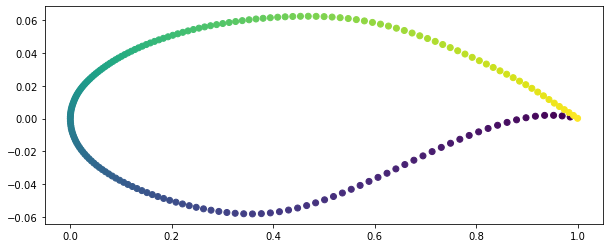

In [34]:
plt.figure(figsize=(10,4))
plt.scatter(df_surface_flow["x"].values, df_surface_flow["y"].values,c=np.linspace(0, 1, 192))

In [7]:
import torch
import torch.nn as nn

tensor = torch.randn(1,100,4)
output = nn.Conv1d(in_channels =100,out_channels=1,kernel_size=1,stride=1)(tensor)

In [36]:
output

tensor([[[ 0.2082, -0.5240, -0.3140, -0.0605]]], grad_fn=<SqueezeBackward1>)

In [38]:
torch.from_numpy(x_in)

tensor([[4757., 4757.],
        [4783., 4783.],
        [4809., 4809.],
        [4835., 4835.],
        [4861., 4861.],
        [4887., 4887.],
        [4913., 4913.],
        [4939., 4939.],
        [4965., 4965.],
        [4991., 4991.],
        [  25.,   25.],
        [  51.,   51.],
        [  77.,   77.],
        [ 103.,  103.],
        [ 129.,  129.],
        [ 155.,  155.],
        [ 181.,  181.],
        [ 207.,  207.],
        [ 233.,  233.],
        [ 259.,  259.],
        [ 285.,  285.],
        [ 311.,  311.],
        [ 337.,  337.],
        [ 363.,  363.],
        [ 389.,  389.],
        [ 415.,  415.],
        [ 441.,  441.],
        [ 467.,  467.],
        [ 493.,  493.],
        [ 519.,  519.],
        [ 545.,  545.],
        [ 571.,  571.],
        [ 597.,  597.],
        [ 623.,  623.],
        [ 649.,  649.],
        [ 675.,  675.],
        [ 701.,  701.],
        [ 727.,  727.],
        [ 753.,  753.],
        [ 779.,  779.],
        [ 805.,  805.],
        [ 831., 

In [39]:
x_torch = torch.from_numpy(x_in.T)
x_torch = x_torch.resize(1,2,212)
x_torch.to(torch.double)

C:\Users\Nils\Anaconda3\envs\MA\lib\site-packages\torch\tensor.py:358: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor([[[4757., 4783., 4809., 4835., 4861., 4887., 4913., 4939., 4965., 4991.,
            25.,   51.,   77.,  103.,  129.,  155.,  181.,  207.,  233.,  259.,
           285.,  311.,  337.,  363.,  389.,  415.,  441.,  467.,  493.,  519.,
           545.,  571.,  597.,  623.,  649.,  675.,  701.,  727.,  753.,  779.,
           805.,  831.,  857.,  883.,  909.,  935.,  961.,  987., 1013., 1039.,
          1065., 1091., 1117., 1143., 1169., 1195., 1221., 1247., 1273., 1299.,
          1325., 1351., 1377., 1403., 1429., 1455., 1481., 1507., 1533., 1559.,
          1585., 1611., 1637., 1663., 1689., 1715., 1741., 1767., 1793., 1819.,
          1845., 1871., 1897., 1923., 1949., 1975., 2001., 2027., 2053., 2079.,
          2105., 2131., 2157., 2183., 2209., 2235., 2261., 2287., 2313., 2339.,
          2365., 2391., 2417., 2443., 2469., 2495., 2521., 2547., 2573., 2599.,
          2625., 2651., 2677., 2703., 2729., 2755., 2781., 2807., 2833., 2859.,
          2885., 2911., 2937., 2963., 29

In [40]:
x_torch

tensor([[[4757., 4783., 4809., 4835., 4861., 4887., 4913., 4939., 4965., 4991.,
            25.,   51.,   77.,  103.,  129.,  155.,  181.,  207.,  233.,  259.,
           285.,  311.,  337.,  363.,  389.,  415.,  441.,  467.,  493.,  519.,
           545.,  571.,  597.,  623.,  649.,  675.,  701.,  727.,  753.,  779.,
           805.,  831.,  857.,  883.,  909.,  935.,  961.,  987., 1013., 1039.,
          1065., 1091., 1117., 1143., 1169., 1195., 1221., 1247., 1273., 1299.,
          1325., 1351., 1377., 1403., 1429., 1455., 1481., 1507., 1533., 1559.,
          1585., 1611., 1637., 1663., 1689., 1715., 1741., 1767., 1793., 1819.,
          1845., 1871., 1897., 1923., 1949., 1975., 2001., 2027., 2053., 2079.,
          2105., 2131., 2157., 2183., 2209., 2235., 2261., 2287., 2313., 2339.,
          2365., 2391., 2417., 2443., 2469., 2495., 2521., 2547., 2573., 2599.,
          2625., 2651., 2677., 2703., 2729., 2755., 2781., 2807., 2833., 2859.,
          2885., 2911., 2937., 2963., 29

In [42]:
#output = nn.Conv1d(in_channels=2, out_channels=1, kernel_size=7,stride=1)(x_torch)

In [43]:
conv = nn.Conv1d(in_channels=2,out_channels=2,kernel_size=7,stride=2)

In [44]:
out = conv(x_torch.float())
out.shape

torch.Size([1, 2, 103])

In [45]:
m = nn.Conv1d(16, 33, 3, stride=2)
input = torch.randn(20, 16, 50)
output = m(input)
output.shape

torch.Size([20, 33, 24])

In [46]:
conv = nn.Conv1d(in_channels=2,out_channels=8,kernel_size=7,stride=1)
input = torch.randn(1, 2, 212)
output = conv(input)
output.shape

torch.Size([1, 8, 206])

In [47]:
input.dtype

torch.float32

In [48]:
conv1 = nn.Conv1d(in_channels=2,out_channels=8,kernel_size=7,stride=1)
conv2 = nn.Conv1d(in_channels=8,out_channels=16,kernel_size=7,stride=2)
conv3 = nn.Conv1d(in_channels=16,out_channels=32,kernel_size=7,stride=3)

In [49]:
conv3(conv2(conv1(input))).shape

torch.Size([1, 32, 32])

In [50]:
from vanillaVAE import VanillaVAE

In [51]:
import vanillaVAE

In [ ]:
modules = []

modules.append(
    nn.Sequential(
        nn.Conv1d(in_channels=2,out_channels=8,kernel_size=7,stride=1)
        nn.BatchNorm1d(h_dim),
        nn.ELU())
    )
    in_channels = h_dim

encoder = nn.Sequential(*modules)

In [350]:
encoder = nn.Sequential(
    nn.Conv1d(in_channels=2,out_channels=8,kernel_size=7,stride=1),
    nn.ELU(),
    nn.Conv1d(in_channels=8,out_channels=16,kernel_size=7,stride=2),
    nn.ELU(),
    nn.Conv1d(in_channels=16,out_channels=16,kernel_size=7,stride=3),
    nn.ELU(),
    nn.Linear(32,8)
)

In [101]:
z = encoder(input)

In [102]:
z.shape, input.shape

(torch.Size([1, 16, 8]), torch.Size([1, 2, 212]))

In [61]:
y_target = torch.from_numpy(df_surface_flow["Pressure_Coefficient"].values)

In [62]:
y_target.shape

torch.Size([192])

In [351]:
decoder = nn.Sequential(
    nn.ConvTranspose1d(in_channels=16,out_channels=8,kernel_size=9,stride=3),
    nn.ELU(),
    nn.ConvTranspose1d(in_channels=8,out_channels=4,kernel_size=7,stride=3),
    nn.ELU(),
    nn.ConvTranspose1d(in_channels=4,out_channels=4,kernel_size=7,stride=2),
    nn.ELU(),
    #nn.Linear(181, 192),
    nn.Conv1d(in_channels=4,out_channels=1,kernel_size=2,stride=1),
    nn.ELU(),
)

In [285]:
decoder(z).shape

torch.Size([1, 1, 192])

In [147]:
decoder.__

SyntaxError: invalid syntax (<ipython-input-147-47bec3442000>, line 1)

In [174]:
for parameter in encoder.parameters():
    print(parameter.shape)

torch.Size([8, 2, 7])
torch.Size([8])
torch.Size([16, 8, 7])
torch.Size([16])
torch.Size([16, 16, 7])
torch.Size([16])
torch.Size([8, 32])
torch.Size([8])


In [176]:
sum(p.numel() for p in decoder.parameters())

1517

In [178]:
!pip install prettytable

In [183]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(encoder)

+----------+------------+
| Modules  | Parameters |
+----------+------------+
| 0.weight |    112     |
|  0.bias  |     8      |
| 2.weight |    896     |
|  2.bias  |     16     |
| 4.weight |    1792    |
|  4.bias  |     16     |
| 6.weight |    256     |
|  6.bias  |     8      |
+----------+------------+
Total Trainable Params: 3104


3104

In [182]:
count_parameters(decoder)

+----------+------------+
| Modules  | Parameters |
+----------+------------+
| 0.weight |    1152    |
|  0.bias  |     8      |
| 2.weight |    224     |
|  2.bias  |     4      |
| 4.weight |    112     |
|  4.bias  |     4      |
| 6.weight |     12     |
|  6.bias  |     1      |
+----------+------------+
Total Trainable Params: 1517


1517

In [8]:
import os

In [9]:
df_surface_flow_total = pd.DataFrame()

for dir in os.listdir("DESIGNS"):
    print(dir)
    try:
        df_surface_flow_dsn = pd.read_csv(os.path.join("DESIGNS", dir, "DIRECT", "surface_flow.csv"))
    except FileNotFoundError:
        print(dir, "FileNotFoundError")
        continue
    df_surface_flow_dsn["DIR"] = dir
    if df_surface_flow_total.empty:
        df_surface_flow_total = df_surface_flow_dsn.copy()
    else:
        df_surface_flow_total = df_surface_flow_total.append(df_surface_flow_dsn)
    print(df_surface_flow_total.shape)

DSN_001
DSN_001 FileNotFoundError
DSN_002
(192, 19)
DSN_003
(384, 19)
DSN_004
(576, 19)
DSN_005
(768, 19)
test.pvsm
test.pvsm FileNotFoundError


In [196]:
df_surface_flow_total = pd.DataFrame()

In [204]:
df_surface_flow_total.empty

False

In [208]:
df_surface_flow_total

,PointID,x,y,Density,Momentum_x,Momentum_y,Energy,Nu_Tilde,Pressure,Temperature,Mach,Pressure_Coefficient,Laminar_Viscosity,Skin_Friction_Coefficient_x,Skin_Friction_Coefficient_y,Heat_Flux,Y_Plus,Eddy_Viscosity,DIR
0,25,0.985397,0.000966,0.465772,0.0,0.0,105948.138328,0.0,42379.255331,316.964100,0.0,0.249552,0.000019,0.002531,-0.000121,-297.574044,2.402825,0.0,DSN_002
1,51,0.969573,0.001624,0.471040,0.0,0.0,107177.736339,0.0,42871.094536,317.057069,0.0,0.283645,0.000019,0.001995,-0.000062,-128.009161,2.144116,0.0,DSN_002
2,77,0.952680,0.001984,0.475066,0.0,0.0,108128.362592,0.0,43251.345037,317.158299,0.0,0.310004,0.000019,0.001705,-0.000017,-73.866300,1.989597,0.0,DSN_002
3,103,0.934996,0.001963,0.476774,0.0,0.0,108538.223261,0.0,43415.289305,317.220200,0.0,0.321368,0.000019,0.001537,0.000023,-52.055137,1.891988,0.0,DSN_002
4,129,0.916822,0.001448,0.476953,0.0,0.0,108587.622855,0.0,43435.049142,317.245060,0.0,0.322738,0.000019,0.001444,0.000057,-43.289854,1.834633,0.0,DSN_002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,4887,0.964163,0.007658,0.443548,0.0,0.0,100906.645495,0.0,40362.658198,317.007468,0.0,0.109765,0.000019,0.000364,-0.000073,20.391614,0.897312,0.0,DSN_005
188,4913,0.973876,0.005690,0.446033,0.0,0.0,101486.942508,0.0,40594.777003,317.054531,0.0,0.125855,0.000019,0.000316,-0.000065,20.573470,0.838222,0.0,DSN_005
189,4939,0.983087,0.003766,0.448586,0.0,0.0,102077.307966,0.0,40830.923186,317.083789,0.0,0.142224,0.000019,0.000330,-0.000069,18.753229,0.859608,0.0,DSN_005
190,4965,0.991850,0.001931,0.450193,0.0,0.0,102435.230104,0.0,40974.092042,317.059353,0.0,0.152148,0.000019,0.000497,-0.000106,10.093965,1.056878,0.0,DSN_005


In [209]:
df_surface_flow_total["DIR"].unique()

array(['DSN_002', 'DSN_003', 'DSN_004', 'DSN_005'], dtype=object)

In [211]:
df_surface_flow_total.groupby("DIR").as_index

True

In [215]:
df_surface_flow_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 191
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PointID                      768 non-null    int64  
 1   x                            768 non-null    float64
 2   y                            768 non-null    float64
 3   Density                      768 non-null    float64
 4   Momentum_x                   768 non-null    float64
 5   Momentum_y                   768 non-null    float64
 6   Energy                       768 non-null    float64
 7   Nu_Tilde                     768 non-null    float64
 8   Pressure                     768 non-null    float64
 9   Temperature                  768 non-null    float64
 10  Mach                         768 non-null    float64
 11  Pressure_Coefficient         768 non-null    float64
 12  Laminar_Viscosity            768 non-null    float64
 13  Skin_Friction_Coeffi

In [17]:
dir_names = sorted(df_surface_flow_total["DIR"].unique().tolist())

In [18]:
N = len(dir_names)
N

380

In [222]:
#df_surface_flow_total.to_csv("df_surface_flow_total.csv")

In [10]:
df_surface_flow_total = pd.read_csv("df_surface_flow_total.csv")

In [11]:
df_surface_flow_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72960 entries, 0 to 72959
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   72960 non-null  int64  
 1   PointID                      72960 non-null  int64  
 2   x                            72960 non-null  float64
 3   y                            72960 non-null  float64
 4   Density                      72960 non-null  float64
 5   Momentum_x                   72960 non-null  float64
 6   Momentum_y                   72960 non-null  float64
 7   Energy                       72960 non-null  float64
 8   Nu_Tilde                     72960 non-null  float64
 9   Pressure                     72960 non-null  float64
 10  Temperature                  72960 non-null  float64
 11  Mach                         72960 non-null  float64
 12  Pressure_Coefficient         72960 non-null  float64
 13  Laminar_Viscosit

In [12]:
df_surface_adjoint_drag_total = pd.read_csv("df_surface_adjoint_drag_total.csv")

In [13]:
df_surface_adjoint_drag_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72960 entries, 0 to 72959
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           72960 non-null  int64  
 1   PointID              72960 non-null  int64  
 2   x                    72960 non-null  float64
 3   y                    72960 non-null  float64
 4   Adjoint_Density      72960 non-null  float64
 5   Adjoint_Momentum_x   72960 non-null  float64
 6   Adjoint_Momentum_y   72960 non-null  float64
 7   Adjoint_Energy       72960 non-null  float64
 8   Sensitivity_x        72960 non-null  float64
 9   Sensitivity_y        72960 non-null  float64
 10  Surface_Sensitivity  72960 non-null  float64
 11  DIR                  72960 non-null  object 
dtypes: float64(9), int64(2), object(1)
memory usage: 6.7+ MB


In [14]:
df_surface = df_surface_flow_total.merge(df_surface_adjoint_drag_total, on=["PointID", "DIR"], suffixes=["", "_right"])

In [15]:
df_surface.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72960 entries, 0 to 72959
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   72960 non-null  int64  
 1   PointID                      72960 non-null  int64  
 2   x                            72960 non-null  float64
 3   y                            72960 non-null  float64
 4   Density                      72960 non-null  float64
 5   Momentum_x                   72960 non-null  float64
 6   Momentum_y                   72960 non-null  float64
 7   Energy                       72960 non-null  float64
 8   Nu_Tilde                     72960 non-null  float64
 9   Pressure                     72960 non-null  float64
 10  Temperature                  72960 non-null  float64
 11  Mach                         72960 non-null  float64
 12  Pressure_Coefficient         72960 non-null  float64
 13  Laminar_Viscosit

In [622]:
np.all(df_surface["x"] == df_surface["x_right"])

True

In [625]:
input_columns = ["x", "y", "Pressure_Coefficient"]
#input_columns = ["x", "y"]

M = len(input_columns)

X = torch.zeros(N, M, 212)
Y = torch.zeros(N, 2, 192)

for i, dir in enumerate(dir_names):
    print(dir)
    df_surface_flow = df_surface[df_surface["DIR"] == dir]
    X[i,:,10:-10] = torch.from_numpy(df_surface_flow[input_columns].values).T
    X[i,:,:10] = torch.from_numpy(df_surface_flow[input_columns].values[-10:]).T
    X[i,:,-10:] = torch.from_numpy(df_surface_flow[input_columns].values[:10]).T
    Y[i,:,:] = torch.from_numpy(df_surface_flow[["Pressure_Coefficient", "Surface_Sensitivity"]].values).T

DSN_002
DSN_003
DSN_004
DSN_005
DSN_006
DSN_007
DSN_008
DSN_009
DSN_010
DSN_011
DSN_012
DSN_013
DSN_014
DSN_015
DSN_016
DSN_017
DSN_018
DSN_019
DSN_020
DSN_021
DSN_022
DSN_023
DSN_024
DSN_025
DSN_026
DSN_027
DSN_028
DSN_029
DSN_030
DSN_031
DSN_032
DSN_033
DSN_034
DSN_035
DSN_036
DSN_037
DSN_038
DSN_039
DSN_040
DSN_041
DSN_042
DSN_043
DSN_044
DSN_045
DSN_046
DSN_047
DSN_048
DSN_049
DSN_050
DSN_051
DSN_052
DSN_053
DSN_054
DSN_055
DSN_056
DSN_057
DSN_058
DSN_059
DSN_060
DSN_061
DSN_062
DSN_063
DSN_064
DSN_065
DSN_066
DSN_067
DSN_068
DSN_069
DSN_070
DSN_071
DSN_072
DSN_073
DSN_074
DSN_075
DSN_076
DSN_077
DSN_078
DSN_079
DSN_080
DSN_081
DSN_082
DSN_083
DSN_084
DSN_085
DSN_086
DSN_087
DSN_088
DSN_089
DSN_090
DSN_091
DSN_092
DSN_093
DSN_094
DSN_095
DSN_096
DSN_097
DSN_098
DSN_099
DSN_100
DSN_101
DSN_102
DSN_103
DSN_104
DSN_105
DSN_106
DSN_107
DSN_108
DSN_109
DSN_110
DSN_111
DSN_112
DSN_113
DSN_114
DSN_115
DSN_116
DSN_117
DSN_118
DSN_119
DSN_120
DSN_121
DSN_122
DSN_123
DSN_124
DSN_125
DSN_126


In [19]:
#input_columns = ["x", "y", "Pressure_Coefficient"]
input_columns = ["x", "y"]

M = len(input_columns)

X = torch.zeros(N, 212, M)
Y = torch.zeros(N, 192, 2)

for i, dir in enumerate(dir_names):
    print(dir)
    df_surface_flow = df_surface[df_surface["DIR"] == dir]
    X[i,10:-10,:] = torch.from_numpy(df_surface_flow[input_columns].values)
    X[i,:10,:] = torch.from_numpy(df_surface_flow[input_columns].values[-10:])
    X[i,-10:,:] = torch.from_numpy(df_surface_flow[input_columns].values[:10])
    Y[i,:,:] = torch.from_numpy(df_surface_flow[["Pressure_Coefficient", "Surface_Sensitivity"]].values)

DSN_002
DSN_003
DSN_004
DSN_005
DSN_006
DSN_007
DSN_008
DSN_009
DSN_010
DSN_011
DSN_012
DSN_013
DSN_014
DSN_015
DSN_016
DSN_017
DSN_018
DSN_019
DSN_020
DSN_021
DSN_022
DSN_023
DSN_024
DSN_025
DSN_026
DSN_027
DSN_028
DSN_029
DSN_030
DSN_031
DSN_032
DSN_033
DSN_034
DSN_035
DSN_036
DSN_037
DSN_038
DSN_039
DSN_040
DSN_041
DSN_042
DSN_043
DSN_044
DSN_045
DSN_046
DSN_047
DSN_048
DSN_049
DSN_050
DSN_051
DSN_052
DSN_053
DSN_054
DSN_055
DSN_056
DSN_057
DSN_058
DSN_059
DSN_060
DSN_061
DSN_062
DSN_063
DSN_064
DSN_065
DSN_066
DSN_067
DSN_068
DSN_069
DSN_070
DSN_071
DSN_072
DSN_073
DSN_074
DSN_075
DSN_076
DSN_077
DSN_078
DSN_079
DSN_080
DSN_081
DSN_082
DSN_083
DSN_084
DSN_085
DSN_086
DSN_087
DSN_088
DSN_089
DSN_090
DSN_091
DSN_092
DSN_093
DSN_094
DSN_095
DSN_096
DSN_097
DSN_098
DSN_099
DSN_100
DSN_101
DSN_102
DSN_103
DSN_104
DSN_105
DSN_106
DSN_107
DSN_108
DSN_109
DSN_110
DSN_111
DSN_112
DSN_113
DSN_114
DSN_115
DSN_116
DSN_117
DSN_118
DSN_119
DSN_120
DSN_121
DSN_122
DSN_123
DSN_124
DSN_125
DSN_126


In [20]:
X_train = X[:360]
X_test = X[360:]
Y_train = Y[:360]
Y_test = Y[360:]


In [21]:
dataset = torch.utils.data.TensorDataset(X_train, Y_train)
loader = torch.utils.data.DataLoader(dataset, batch_size=36, shuffle=True, pin_memory=True)

In [805]:
class TestModel(nn.Module):
    def __init__(self):
        super(TestModel, self).__init__()
        
        self.embed_dim = 16
        
        self.q = nn.Linear(3, self.embed_dim)
        self.k = nn.Linear(3, self.embed_dim)
        self.v = nn.Linear(3, self.embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim=self.embed_dim, num_heads=8, dropout=0.1)
        
        self.encoder = nn.Sequential(
            #nn.TransformerEncoderLayer(d_model=M, nhead=16),
            #nn.Conv1d(in_channels=M,out_channels=16,kernel_size=15,stride=1),
            #nn.SELU(),
            #nn.AlphaDropout(0.1),
            nn.Conv1d(in_channels=self.embed_dim,out_channels=32,kernel_size=15,stride=2),
            nn.SELU(),
            nn.AlphaDropout(0.1),
            nn.Conv1d(in_channels=32,out_channels=16,kernel_size=15,stride=3),
            nn.SELU(),
            nn.AlphaDropout(0.1),
            nn.Linear(29,16),
            nn.SELU(),
            nn.Linear(16,16),
            nn.SELU(),
            nn.Linear(16,8)
        )
        #self.conv1 = nn.Conv1d(in_channels=64,out_channels=32,kernel_size=15,stride=2)
        #self.selu1 = nn.SELU()
        #self.alpha_do1 = nn.AlphaDropout(0.1)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16,out_channels=8,kernel_size=9,stride=3),
            nn.SELU(),
            nn.ConvTranspose1d(in_channels=8,out_channels=4,kernel_size=7,stride=3),
            nn.SELU(),
            nn.ConvTranspose1d(in_channels=4,out_channels=2,kernel_size=7,stride=2),
            #nn.ELU(),
            nn.Linear(193, 192),
            #nn.Conv1d(in_channels=4,out_channels=1,kernel_size=2,stride=1),
            #nn.ELU(),
           # nn.SELU(),
           # nn.AlphaDropout(0.1),
        )
        
        self.out = nn.Linear(64, 1)
    
    def forward(self, x):
        q, k, v = self.q(x), self.k(x), self.v(x)
        z, _ = self.mha(q, k, v)
        #print(z.shape)
        #z2 = self.encoder(z)
        z_T = z.transpose(1,2)
        z2 = self.encoder(z_T)
        out = self.decoder(z2).transpose(1,2)
        return(out)
        #return self.out(z)
        #return self.out(q+k+v)

In [22]:
class TestModel(nn.Module):
    def __init__(self):
        super(TestModel, self).__init__()
        
        self.hidden_size = 16
        self.bidirectional = False
        
        self.gru = nn.GRU(input_size=M, hidden_size=self.hidden_size, bidirectional=self.bidirectional, dropout=0.1)
        self.skip1 = nn.Linear(M, self.hidden_size)
        #self.pool1 = nn.MaxPool1d()
        
        self.encoder = nn.Sequential(
            #nn.TransformerEncoderLayer(d_model=M, nhead=16),
            #nn.Conv1d(in_channels=M,out_channels=16,kernel_size=15,stride=1),
            #nn.SELU(),
            #nn.AlphaDropout(0.1),
            nn.Conv1d(in_channels=self.hidden_size*2,out_channels=32,kernel_size=15,stride=2),
            nn.SELU(),
            nn.AlphaDropout(0.1),
            nn.Conv1d(in_channels=32,out_channels=16,kernel_size=15,stride=3),
            nn.SELU(),
            nn.AlphaDropout(0.1),
            nn.Linear(29,16),
            nn.SELU(),
            nn.Linear(16,16),
            nn.SELU(),
            nn.Linear(16,8)
        )
        #self.conv1 = nn.Conv1d(in_channels=64,out_channels=32,kernel_size=15,stride=2)
        #self.selu1 = nn.SELU()
        #self.alpha_do1 = nn.AlphaDropout(0.1)
        #self.skip2 = nn.Linear(2,)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16,out_channels=8,kernel_size=9,stride=3),
            nn.SELU(),
            nn.ConvTranspose1d(in_channels=8,out_channels=4,kernel_size=7,stride=3),
            nn.SELU(),
            nn.ConvTranspose1d(in_channels=4,out_channels=2,kernel_size=7,stride=2),
            #nn.ELU(),
            nn.Linear(193, 192),
            #nn.Conv1d(in_channels=4,out_channels=1,kernel_size=2,stride=1),
            #nn.ELU(),
           # nn.SELU(),
           # nn.AlphaDropout(0.1),
        )
        
        self.out = nn.Linear(64, 1)
    
    def forward(self, x, h):
        #q, k, v = self.q(x), self.k(x), self.v(x)
        #z, _ = self.mha(q, k, v)
        
        z, h = self.gru(x, h)
        z_skip = self.skip1(x)
        
        z_cat = torch.cat((z, z_skip), dim=2)
        
        #print(z.shape)
        #z2 = self.encoder(z)
        z_T = z_cat.transpose(1,2)
        z2 = self.encoder(z_T)
        out = self.decoder(z2).transpose(1,2)
        return(out, h)
        #return self.out(z)
        
    def init_hidden(self):
        if self.bidirectional:
            return(torch.zeros(2, 212, self.hidden_size))
        else:
            return(torch.zeros(1, 212, self.hidden_size))

In [915]:
z = torch.rand(5, 212, 2)
z_skip = tm.skip1(z)
z.shape, z_skip.shape

(torch.Size([5, 212, 2]), torch.Size([5, 212, 16]))

In [919]:
torch.cat((z, z_skip), dim=2).shape

torch.Size([5, 212, 18])

In [921]:
tm = TestModel()
#tm(X[:5,:,:]).shape

h0 = tm.init_hidden()
out, h = tm(X[:5], h0)

C:\Users\Nils\Anaconda3\envs\MA\lib\site-packages\torch\nn\modules\rnn.py:57: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [910]:
tm.skip1(X[:5]).shape

torch.Size([5, 212, 16])

In [909]:
X[:5].shape, h0.shape

(torch.Size([5, 212, 2]), torch.Size([1, 212, 16]))

In [842]:
out.shape, h.shape

(torch.Size([5, 192, 2]), torch.Size([1, 212, 16]))

In [733]:
X.shape

torch.Size([360, 212, 3])

In [765]:
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, bidirectional = True, batch_first=True, num_layers=3):
    super(Encoder, self).__init__()
    self.hidden_size = hidden_size
    self.input_size = input_size
    self.bidirectional = bidirectional
    
    self.gru = nn.GRU(input_size, hidden_size, bidirectional = bidirectional, dropout=0.1)
  
  def forward(self, inputs, hidden):
    
    output, hidden = self.gru(inputs, hidden)
    return output, hidden
    
  def init_hidden(self):
    if self.bidirectional:
        return(torch.zeros(2, 212, self.hidden_size))
    else:
        return(torch.zeros(1, 212, self.hidden_size))
    
    #return (torch.zeros(1 + int(self.bidirectional), 1, self.hidden_size),
    #  torch.zeros(1 + int(self.bidirectional), 1, self.hidden_size))

enc = Encoder(3, 48, True)
enc.eval()
#h = h_a, h_b = enc.init_hidden()
h
#h0 = torch.zeros(1, 212, 32)
h0 = enc.init_hidden()
out, h = enc(X[:5], h0)

out.shape, h.shape

(torch.Size([5, 212, 96]), torch.Size([2, 212, 48]))

In [767]:
out.transpose(1,2).shape

torch.Size([5, 96, 212])

In [678]:
encoder = nn.Sequential(
    #nn.TransformerEncoderLayer(d_model=M, nhead=16),
    nn.Conv1d(in_channels=M,out_channels=16,kernel_size=15,stride=1),
    nn.SELU(),
    nn.AlphaDropout(0.1),
    nn.Conv1d(in_channels=16,out_channels=32,kernel_size=15,stride=2),
    nn.SELU(),
    nn.AlphaDropout(0.1),
    nn.Conv1d(in_channels=32,out_channels=32,kernel_size=15,stride=3),
    nn.SELU(),
    nn.AlphaDropout(0.1),
    nn.Linear(26,32),
    nn.SELU(),
    nn.Linear(32,32),
    nn.SELU(),
    nn.Linear(32,8)
)

decoder = nn.Sequential(
    nn.ConvTranspose1d(in_channels=32,out_channels=8,kernel_size=9,stride=3),
    nn.SELU(),
    nn.ConvTranspose1d(in_channels=8,out_channels=4,kernel_size=7,stride=3),
    nn.SELU(),
    nn.ConvTranspose1d(in_channels=4,out_channels=2,kernel_size=7,stride=2),
    #nn.ELU(),
    nn.Linear(193, 192),
    #nn.Conv1d(in_channels=4,out_channels=1,kernel_size=2,stride=1),
    #nn.ELU(),
)

net = nn.Sequential(encoder, decoder)#.cuda()

z = encoder(torch.randn(2,M,212))

print(z.shape) 
out = decoder(z)

out.shape

AssertionError: embed_dim must be divisible by num_heads

In [23]:
#net = nn.Sequential(encoder, decoder)
net = TestModel()

C:\Users\Nils\Anaconda3\envs\MA\lib\site-packages\torch\nn\modules\rnn.py:57: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [24]:
count_parameters(net)

NameError: name 'count_parameters' is not defined

In [46]:
import torch.optim as optim



criterion = nn.MSELoss()
#optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)
optimizer = optim.Adagrad(net.parameters(),)
#optimizer = optim.Adam(net.parameters(),)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.95)

In [47]:
net.train()

for epoch in range(20000):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, target = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #outputs = net(inputs)
        
        h0 = net.init_hidden()
        outputs, h = net(inputs, h0)
        
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
    scheduler.step()
    print(scheduler.get_last_lr())
print('Finished Training')

[1,    10] loss: 0.012018
[0.01]
[2,    10] loss: 0.003149
[0.01]
[3,    10] loss: 0.003127
[0.01]
[4,    10] loss: 0.003126
[0.01]
[5,    10] loss: 0.003145
[0.01]
[6,    10] loss: 0.003118
[0.01]
[7,    10] loss: 0.003115
[0.01]
[8,    10] loss: 0.003131
[0.01]
[9,    10] loss: 0.003106
[0.01]
[10,    10] loss: 0.003102
[0.01]
[11,    10] loss: 0.003125
[0.01]
[12,    10] loss: 0.003114
[0.01]
[13,    10] loss: 0.003119
[0.01]
[14,    10] loss: 0.003110
[0.01]
[15,    10] loss: 0.003144
[0.01]
[16,    10] loss: 0.003103
[0.01]
[17,    10] loss: 0.003116
[0.01]
[18,    10] loss: 0.003092
[0.01]
[19,    10] loss: 0.003112
[0.01]
[20,    10] loss: 0.003121
[0.01]
[21,    10] loss: 0.003113
[0.01]
[22,    10] loss: 0.003106
[0.01]
[23,    10] loss: 0.003110
[0.01]
[24,    10] loss: 0.003100
[0.01]
[25,    10] loss: 0.003129
[0.01]
[26,    10] loss: 0.003103
[0.01]
[27,    10] loss: 0.003097
[0.01]
[28,    10] loss: 0.003107
[0.01]
[29,    10] loss: 0.003094
[0.01]
[30,    10] loss: 0.003

[199,    10] loss: 0.003083
[0.007350918906249998]
[200,    10] loss: 0.003091
[0.007350918906249998]
[201,    10] loss: 0.003086
[0.007350918906249998]
[202,    10] loss: 0.003082
[0.007350918906249998]
[203,    10] loss: 0.003087
[0.007350918906249998]
[204,    10] loss: 0.003084
[0.007350918906249998]
[205,    10] loss: 0.003080
[0.007350918906249998]
[206,    10] loss: 0.003089
[0.007350918906249998]
[207,    10] loss: 0.003087
[0.007350918906249998]
[208,    10] loss: 0.003085
[0.007350918906249998]
[209,    10] loss: 0.003088
[0.007350918906249998]
[210,    10] loss: 0.003081
[0.006983372960937498]
[211,    10] loss: 0.003090
[0.006983372960937498]
[212,    10] loss: 0.003083
[0.006983372960937498]
[213,    10] loss: 0.003087
[0.006983372960937498]
[214,    10] loss: 0.003081
[0.006983372960937498]
[215,    10] loss: 0.003079
[0.006983372960937498]
[216,    10] loss: 0.003080
[0.006983372960937498]
[217,    10] loss: 0.003087
[0.006983372960937498]
[218,    10] loss: 0.003089
[0.

[360,    10] loss: 0.003079
[0.005403600876626367]
[361,    10] loss: 0.003081
[0.005403600876626367]
[362,    10] loss: 0.003082
[0.005403600876626367]
[363,    10] loss: 0.003079
[0.005403600876626367]
[364,    10] loss: 0.003081
[0.005403600876626367]
[365,    10] loss: 0.003082
[0.005403600876626367]
[366,    10] loss: 0.003079
[0.005403600876626367]
[367,    10] loss: 0.003082
[0.005403600876626367]
[368,    10] loss: 0.003081
[0.005403600876626367]
[369,    10] loss: 0.003080
[0.005403600876626367]
[370,    10] loss: 0.003081
[0.005403600876626367]
[371,    10] loss: 0.003081
[0.005403600876626367]
[372,    10] loss: 0.003077
[0.005403600876626367]
[373,    10] loss: 0.003081
[0.005403600876626367]
[374,    10] loss: 0.003080
[0.005403600876626367]
[375,    10] loss: 0.003080
[0.005403600876626367]
[376,    10] loss: 0.003083
[0.005403600876626367]
[377,    10] loss: 0.003082
[0.005403600876626367]
[378,    10] loss: 0.003081
[0.005403600876626367]
[379,    10] loss: 0.003082
[0.

[521,    10] loss: 0.003077
[0.004181203352191771]
[522,    10] loss: 0.003077
[0.004181203352191771]
[523,    10] loss: 0.003078
[0.004181203352191771]
[524,    10] loss: 0.003079
[0.004181203352191771]
[525,    10] loss: 0.003078
[0.004181203352191771]
[526,    10] loss: 0.003078
[0.004181203352191771]
[527,    10] loss: 0.003079
[0.004181203352191771]
[528,    10] loss: 0.003076
[0.004181203352191771]
[529,    10] loss: 0.003078
[0.004181203352191771]
[530,    10] loss: 0.003078
[0.004181203352191771]
[531,    10] loss: 0.003079
[0.004181203352191771]
[532,    10] loss: 0.003076
[0.004181203352191771]
[533,    10] loss: 0.003077
[0.004181203352191771]
[534,    10] loss: 0.003079
[0.004181203352191771]
[535,    10] loss: 0.003076
[0.004181203352191771]
[536,    10] loss: 0.003076
[0.004181203352191771]
[537,    10] loss: 0.003076
[0.004181203352191771]
[538,    10] loss: 0.003076
[0.004181203352191771]
[539,    10] loss: 0.003078
[0.004181203352191771]
[540,    10] loss: 0.003077
[0.

[680,    10] loss: 0.003077
[0.0032353354497370902]
[681,    10] loss: 0.003075
[0.0032353354497370902]
[682,    10] loss: 0.003075
[0.0032353354497370902]
[683,    10] loss: 0.003077
[0.0032353354497370902]
[684,    10] loss: 0.003077
[0.0032353354497370902]
[685,    10] loss: 0.003075
[0.0032353354497370902]
[686,    10] loss: 0.003075
[0.0032353354497370902]
[687,    10] loss: 0.003077
[0.0032353354497370902]
[688,    10] loss: 0.003076
[0.0032353354497370902]
[689,    10] loss: 0.003076
[0.0032353354497370902]
[690,    10] loss: 0.003076
[0.0030735686772502355]
[691,    10] loss: 0.003077
[0.0030735686772502355]
[692,    10] loss: 0.003074
[0.0030735686772502355]
[693,    10] loss: 0.003075
[0.0030735686772502355]
[694,    10] loss: 0.003078
[0.0030735686772502355]
[695,    10] loss: 0.003076
[0.0030735686772502355]
[696,    10] loss: 0.003077
[0.0030735686772502355]
[697,    10] loss: 0.003076
[0.0030735686772502355]
[698,    10] loss: 0.003075
[0.0030735686772502355]
[699,    10]

[839,    10] loss: 0.003074
[0.002503440897424549]
[840,    10] loss: 0.003075
[0.0023782688525533216]
[841,    10] loss: 0.003074
[0.0023782688525533216]
[842,    10] loss: 0.003075
[0.0023782688525533216]
[843,    10] loss: 0.003076
[0.0023782688525533216]
[844,    10] loss: 0.003074
[0.0023782688525533216]
[845,    10] loss: 0.003075
[0.0023782688525533216]
[846,    10] loss: 0.003075
[0.0023782688525533216]
[847,    10] loss: 0.003074
[0.0023782688525533216]
[848,    10] loss: 0.003074
[0.0023782688525533216]
[849,    10] loss: 0.003075
[0.0023782688525533216]
[850,    10] loss: 0.003074
[0.0023782688525533216]
[851,    10] loss: 0.003074
[0.0023782688525533216]
[852,    10] loss: 0.003074
[0.0023782688525533216]
[853,    10] loss: 0.003075
[0.0023782688525533216]
[854,    10] loss: 0.003075
[0.0023782688525533216]
[855,    10] loss: 0.003073
[0.0023782688525533216]
[856,    10] loss: 0.003075
[0.0023782688525533216]
[857,    10] loss: 0.003074
[0.0023782688525533216]
[858,    10] 

[997,    10] loss: 0.003074
[0.0018402591023557579]
[998,    10] loss: 0.003074
[0.0018402591023557579]
[999,    10] loss: 0.003074
[0.0018402591023557579]
[1000,    10] loss: 0.003074
[0.0018402591023557579]
[1001,    10] loss: 0.003073
[0.0018402591023557579]
[1002,    10] loss: 0.003073
[0.0018402591023557579]
[1003,    10] loss: 0.003074
[0.0018402591023557579]
[1004,    10] loss: 0.003073
[0.0018402591023557579]
[1005,    10] loss: 0.003074
[0.0018402591023557579]
[1006,    10] loss: 0.003076
[0.0018402591023557579]
[1007,    10] loss: 0.003073
[0.0018402591023557579]
[1008,    10] loss: 0.003075
[0.0018402591023557579]
[1009,    10] loss: 0.003076
[0.0018402591023557579]
[1010,    10] loss: 0.003074
[0.0018402591023557579]
[1011,    10] loss: 0.003074
[0.0018402591023557579]
[1012,    10] loss: 0.003073
[0.0018402591023557579]
[1013,    10] loss: 0.003074
[0.0018402591023557579]
[1014,    10] loss: 0.003074
[0.0018402591023557579]
[1015,    10] loss: 0.003076
[0.00184025910235575

[1153,    10] loss: 0.003073
[0.0014239574134637463]
[1154,    10] loss: 0.003073
[0.0014239574134637463]
[1155,    10] loss: 0.003073
[0.0014239574134637463]
[1156,    10] loss: 0.003074
[0.0014239574134637463]
[1157,    10] loss: 0.003074
[0.0014239574134637463]
[1158,    10] loss: 0.003073
[0.0014239574134637463]
[1159,    10] loss: 0.003073
[0.0014239574134637463]
[1160,    10] loss: 0.003074
[0.0014239574134637463]
[1161,    10] loss: 0.003074
[0.0014239574134637463]
[1162,    10] loss: 0.003073
[0.0014239574134637463]
[1163,    10] loss: 0.003072
[0.0014239574134637463]
[1164,    10] loss: 0.003073
[0.0014239574134637463]
[1165,    10] loss: 0.003074
[0.0014239574134637463]
[1166,    10] loss: 0.003074
[0.0014239574134637463]
[1167,    10] loss: 0.003074
[0.0014239574134637463]
[1168,    10] loss: 0.003073
[0.0014239574134637463]
[1169,    10] loss: 0.003074
[0.0014239574134637463]
[1170,    10] loss: 0.003073
[0.0013527595427905588]
[1171,    10] loss: 0.003074
[0.00135275954279

[1308,    10] loss: 0.003072
[0.0011018311023500522]
[1309,    10] loss: 0.003073
[0.0011018311023500522]
[1310,    10] loss: 0.003073
[0.0011018311023500522]
[1311,    10] loss: 0.003073
[0.0011018311023500522]
[1312,    10] loss: 0.003072
[0.0011018311023500522]
[1313,    10] loss: 0.003073
[0.0011018311023500522]
[1314,    10] loss: 0.003074
[0.0011018311023500522]
[1315,    10] loss: 0.003073
[0.0011018311023500522]
[1316,    10] loss: 0.003073
[0.0011018311023500522]
[1317,    10] loss: 0.003073
[0.0011018311023500522]
[1318,    10] loss: 0.003073
[0.0011018311023500522]
[1319,    10] loss: 0.003073
[0.0011018311023500522]
[1320,    10] loss: 0.003073
[0.0010467395472325495]
[1321,    10] loss: 0.003073
[0.0010467395472325495]
[1322,    10] loss: 0.003073
[0.0010467395472325495]
[1323,    10] loss: 0.003073
[0.0010467395472325495]
[1324,    10] loss: 0.003072
[0.0010467395472325495]
[1325,    10] loss: 0.003073
[0.0010467395472325495]
[1326,    10] loss: 0.003073
[0.00104673954723

[1464,    10] loss: 0.003073
[0.0008525759033430817]
[1465,    10] loss: 0.003073
[0.0008525759033430817]
[1466,    10] loss: 0.003073
[0.0008525759033430817]
[1467,    10] loss: 0.003072
[0.0008525759033430817]
[1468,    10] loss: 0.003073
[0.0008525759033430817]
[1469,    10] loss: 0.003073
[0.0008525759033430817]
[1470,    10] loss: 0.003073
[0.0008099471081759276]
[1471,    10] loss: 0.003073
[0.0008099471081759276]
[1472,    10] loss: 0.003073
[0.0008099471081759276]
[1473,    10] loss: 0.003073
[0.0008099471081759276]
[1474,    10] loss: 0.003073
[0.0008099471081759276]
[1475,    10] loss: 0.003072
[0.0008099471081759276]
[1476,    10] loss: 0.003073
[0.0008099471081759276]
[1477,    10] loss: 0.003073
[0.0008099471081759276]
[1478,    10] loss: 0.003073
[0.0008099471081759276]
[1479,    10] loss: 0.003073
[0.0008099471081759276]
[1480,    10] loss: 0.003073
[0.0008099471081759276]
[1481,    10] loss: 0.003073
[0.0008099471081759276]
[1482,    10] loss: 0.003073
[0.00080994710817

[1619,    10] loss: 0.003072
[0.0006597069817787191]
[1620,    10] loss: 0.003073
[0.0006267216326897832]
[1621,    10] loss: 0.003073
[0.0006267216326897832]
[1622,    10] loss: 0.003072
[0.0006267216326897832]
[1623,    10] loss: 0.003073
[0.0006267216326897832]
[1624,    10] loss: 0.003072
[0.0006267216326897832]
[1625,    10] loss: 0.003072
[0.0006267216326897832]
[1626,    10] loss: 0.003072
[0.0006267216326897832]
[1627,    10] loss: 0.003073
[0.0006267216326897832]
[1628,    10] loss: 0.003072
[0.0006267216326897832]
[1629,    10] loss: 0.003073
[0.0006267216326897832]
[1630,    10] loss: 0.003073
[0.0006267216326897832]
[1631,    10] loss: 0.003072
[0.0006267216326897832]
[1632,    10] loss: 0.003072
[0.0006267216326897832]
[1633,    10] loss: 0.003072
[0.0006267216326897832]
[1634,    10] loss: 0.003073
[0.0006267216326897832]
[1635,    10] loss: 0.003072
[0.0006267216326897832]
[1636,    10] loss: 0.003072
[0.0006267216326897832]
[1637,    10] loss: 0.003073
[0.00062672163268

[1775,    10] loss: 0.003073
[0.0004849452524942309]
[1776,    10] loss: 0.003072
[0.0004849452524942309]
[1777,    10] loss: 0.003072
[0.0004849452524942309]
[1778,    10] loss: 0.003073
[0.0004849452524942309]
[1779,    10] loss: 0.003072
[0.0004849452524942309]
[1780,    10] loss: 0.003072
[0.0004849452524942309]
[1781,    10] loss: 0.003072
[0.0004849452524942309]
[1782,    10] loss: 0.003073
[0.0004849452524942309]
[1783,    10] loss: 0.003072
[0.0004849452524942309]
[1784,    10] loss: 0.003072
[0.0004849452524942309]
[1785,    10] loss: 0.003072
[0.0004849452524942309]
[1786,    10] loss: 0.003072
[0.0004849452524942309]
[1787,    10] loss: 0.003072
[0.0004849452524942309]
[1788,    10] loss: 0.003073
[0.0004849452524942309]
[1789,    10] loss: 0.003073
[0.0004849452524942309]
[1790,    10] loss: 0.003072
[0.0004849452524942309]
[1791,    10] loss: 0.003072
[0.0004849452524942309]
[1792,    10] loss: 0.003072
[0.0004849452524942309]
[1793,    10] loss: 0.003073
[0.00048494525249

[1929,    10] loss: 0.003072
[0.0003752413921111601]
[1930,    10] loss: 0.003072
[0.0003752413921111601]
[1931,    10] loss: 0.003072
[0.0003752413921111601]
[1932,    10] loss: 0.003072
[0.0003752413921111601]
[1933,    10] loss: 0.003072
[0.0003752413921111601]
[1934,    10] loss: 0.003072
[0.0003752413921111601]
[1935,    10] loss: 0.003072
[0.0003752413921111601]
[1936,    10] loss: 0.003072
[0.0003752413921111601]
[1937,    10] loss: 0.003072
[0.0003752413921111601]
[1938,    10] loss: 0.003072
[0.0003752413921111601]
[1939,    10] loss: 0.003072
[0.0003752413921111601]
[1940,    10] loss: 0.003072
[0.0003752413921111601]
[1941,    10] loss: 0.003072
[0.0003752413921111601]
[1942,    10] loss: 0.003072
[0.0003752413921111601]
[1943,    10] loss: 0.003073
[0.0003752413921111601]
[1944,    10] loss: 0.003072
[0.0003752413921111601]
[1945,    10] loss: 0.003072
[0.0003752413921111601]
[1946,    10] loss: 0.003072
[0.0003752413921111601]
[1947,    10] loss: 0.003072
[0.00037524139211

[2082,    10] loss: 0.003072
[0.0002903546361765785]
[2083,    10] loss: 0.003072
[0.0002903546361765785]
[2084,    10] loss: 0.003072
[0.0002903546361765785]
[2085,    10] loss: 0.003072
[0.0002903546361765785]
[2086,    10] loss: 0.003072
[0.0002903546361765785]
[2087,    10] loss: 0.003072
[0.0002903546361765785]
[2088,    10] loss: 0.003072
[0.0002903546361765785]
[2089,    10] loss: 0.003072
[0.0002903546361765785]
[2090,    10] loss: 0.003072
[0.0002903546361765785]
[2091,    10] loss: 0.003072
[0.0002903546361765785]
[2092,    10] loss: 0.003072
[0.0002903546361765785]
[2093,    10] loss: 0.003072
[0.0002903546361765785]
[2094,    10] loss: 0.003072
[0.0002903546361765785]
[2095,    10] loss: 0.003072
[0.0002903546361765785]
[2096,    10] loss: 0.003072
[0.0002903546361765785]
[2097,    10] loss: 0.003072
[0.0002903546361765785]
[2098,    10] loss: 0.003072
[0.0002903546361765785]
[2099,    10] loss: 0.003072
[0.0002903546361765785]
[2100,    10] loss: 0.003073
[0.00027583690436

[2235,    10] loss: 0.003072
[0.00022467088258818426]
[2236,    10] loss: 0.003072
[0.00022467088258818426]
[2237,    10] loss: 0.003072
[0.00022467088258818426]
[2238,    10] loss: 0.003072
[0.00022467088258818426]
[2239,    10] loss: 0.003072
[0.00022467088258818426]
[2240,    10] loss: 0.003072
[0.00022467088258818426]
[2241,    10] loss: 0.003072
[0.00022467088258818426]
[2242,    10] loss: 0.003072
[0.00022467088258818426]
[2243,    10] loss: 0.003072
[0.00022467088258818426]
[2244,    10] loss: 0.003072
[0.00022467088258818426]
[2245,    10] loss: 0.003072
[0.00022467088258818426]
[2246,    10] loss: 0.003072
[0.00022467088258818426]
[2247,    10] loss: 0.003072
[0.00022467088258818426]
[2248,    10] loss: 0.003072
[0.00022467088258818426]
[2249,    10] loss: 0.003072
[0.00022467088258818426]
[2250,    10] loss: 0.003072
[0.00021343733845877503]
[2251,    10] loss: 0.003072
[0.00021343733845877503]
[2252,    10] loss: 0.003073
[0.00021343733845877503]
[2253,    10] loss: 0.003072

[2388,    10] loss: 0.003072
[0.0001738460461580376]
[2389,    10] loss: 0.003072
[0.0001738460461580376]
[2390,    10] loss: 0.003072
[0.0001738460461580376]
[2391,    10] loss: 0.003072
[0.0001738460461580376]
[2392,    10] loss: 0.003072
[0.0001738460461580376]
[2393,    10] loss: 0.003073
[0.0001738460461580376]
[2394,    10] loss: 0.003072
[0.0001738460461580376]
[2395,    10] loss: 0.003072
[0.0001738460461580376]
[2396,    10] loss: 0.003072
[0.0001738460461580376]
[2397,    10] loss: 0.003072
[0.0001738460461580376]
[2398,    10] loss: 0.003072
[0.0001738460461580376]
[2399,    10] loss: 0.003072
[0.0001738460461580376]
[2400,    10] loss: 0.003072
[0.00016515374385013573]
[2401,    10] loss: 0.003072
[0.00016515374385013573]
[2402,    10] loss: 0.003072
[0.00016515374385013573]
[2403,    10] loss: 0.003071
[0.00016515374385013573]
[2404,    10] loss: 0.003072
[0.00016515374385013573]
[2405,    10] loss: 0.003072
[0.00016515374385013573]
[2406,    10] loss: 0.003072
[0.00016515

[2541,    10] loss: 0.003072
[0.00013451875657683458]
[2542,    10] loss: 0.003072
[0.00013451875657683458]
[2543,    10] loss: 0.003072
[0.00013451875657683458]
[2544,    10] loss: 0.003072
[0.00013451875657683458]
[2545,    10] loss: 0.003072
[0.00013451875657683458]
[2546,    10] loss: 0.003072
[0.00013451875657683458]
[2547,    10] loss: 0.003072
[0.00013451875657683458]
[2548,    10] loss: 0.003072
[0.00013451875657683458]
[2549,    10] loss: 0.003072
[0.00013451875657683458]
[2550,    10] loss: 0.003072
[0.00012779281874799285]
[2551,    10] loss: 0.003072
[0.00012779281874799285]
[2552,    10] loss: 0.003072
[0.00012779281874799285]
[2553,    10] loss: 0.003072
[0.00012779281874799285]
[2554,    10] loss: 0.003072
[0.00012779281874799285]
[2555,    10] loss: 0.003072
[0.00012779281874799285]
[2556,    10] loss: 0.003072
[0.00012779281874799285]
[2557,    10] loss: 0.003072
[0.00012779281874799285]
[2558,    10] loss: 0.003072
[0.00012779281874799285]
[2559,    10] loss: 0.003072

[2694,    10] loss: 0.003072
[0.00010408804957535733]
[2695,    10] loss: 0.003072
[0.00010408804957535733]
[2696,    10] loss: 0.003072
[0.00010408804957535733]
[2697,    10] loss: 0.003072
[0.00010408804957535733]
[2698,    10] loss: 0.003072
[0.00010408804957535733]
[2699,    10] loss: 0.003072
[0.00010408804957535733]
[2700,    10] loss: 0.003072
[9.888364709658946e-05]
[2701,    10] loss: 0.003072
[9.888364709658946e-05]
[2702,    10] loss: 0.003072
[9.888364709658946e-05]
[2703,    10] loss: 0.003072
[9.888364709658946e-05]
[2704,    10] loss: 0.003072
[9.888364709658946e-05]
[2705,    10] loss: 0.003072
[9.888364709658946e-05]
[2706,    10] loss: 0.003072
[9.888364709658946e-05]
[2707,    10] loss: 0.003071
[9.888364709658946e-05]
[2708,    10] loss: 0.003072
[9.888364709658946e-05]
[2709,    10] loss: 0.003072
[9.888364709658946e-05]
[2710,    10] loss: 0.003072
[9.888364709658946e-05]
[2711,    10] loss: 0.003072
[9.888364709658946e-05]
[2712,    10] loss: 0.003072
[9.88836470

[2849,    10] loss: 0.003072
[8.054134858296645e-05]
[2850,    10] loss: 0.003072
[7.651428115381812e-05]
[2851,    10] loss: 0.003072
[7.651428115381812e-05]
[2852,    10] loss: 0.003072
[7.651428115381812e-05]
[2853,    10] loss: 0.003072
[7.651428115381812e-05]
[2854,    10] loss: 0.003071
[7.651428115381812e-05]
[2855,    10] loss: 0.003072
[7.651428115381812e-05]
[2856,    10] loss: 0.003072
[7.651428115381812e-05]
[2857,    10] loss: 0.003072
[7.651428115381812e-05]
[2858,    10] loss: 0.003072
[7.651428115381812e-05]
[2859,    10] loss: 0.003072
[7.651428115381812e-05]
[2860,    10] loss: 0.003072
[7.651428115381812e-05]
[2861,    10] loss: 0.003072
[7.651428115381812e-05]
[2862,    10] loss: 0.003072
[7.651428115381812e-05]
[2863,    10] loss: 0.003072
[7.651428115381812e-05]
[2864,    10] loss: 0.003071
[7.651428115381812e-05]
[2865,    10] loss: 0.003072
[7.651428115381812e-05]
[2866,    10] loss: 0.003072
[7.651428115381812e-05]
[2867,    10] loss: 0.003071
[7.65142811538181

[3005,    10] loss: 0.003071
[5.920529220333995e-05]
[3006,    10] loss: 0.003072
[5.920529220333995e-05]
[3007,    10] loss: 0.003072
[5.920529220333995e-05]
[3008,    10] loss: 0.003072
[5.920529220333995e-05]
[3009,    10] loss: 0.003072
[5.920529220333995e-05]
[3010,    10] loss: 0.003072
[5.920529220333995e-05]
[3011,    10] loss: 0.003072
[5.920529220333995e-05]
[3012,    10] loss: 0.003072
[5.920529220333995e-05]
[3013,    10] loss: 0.003072
[5.920529220333995e-05]
[3014,    10] loss: 0.003072
[5.920529220333995e-05]
[3015,    10] loss: 0.003072
[5.920529220333995e-05]
[3016,    10] loss: 0.003072
[5.920529220333995e-05]
[3017,    10] loss: 0.003072
[5.920529220333995e-05]
[3018,    10] loss: 0.003072
[5.920529220333995e-05]
[3019,    10] loss: 0.003072
[5.920529220333995e-05]
[3020,    10] loss: 0.003072
[5.920529220333995e-05]
[3021,    10] loss: 0.003072
[5.920529220333995e-05]
[3022,    10] loss: 0.003072
[5.920529220333995e-05]
[3023,    10] loss: 0.003072
[5.92052922033399

[3158,    10] loss: 0.003072
[4.581192650606181e-05]
[3159,    10] loss: 0.003071
[4.581192650606181e-05]
[3160,    10] loss: 0.003072
[4.581192650606181e-05]
[3161,    10] loss: 0.003072
[4.581192650606181e-05]
[3162,    10] loss: 0.003072
[4.581192650606181e-05]
[3163,    10] loss: 0.003072
[4.581192650606181e-05]
[3164,    10] loss: 0.003072
[4.581192650606181e-05]
[3165,    10] loss: 0.003072
[4.581192650606181e-05]
[3166,    10] loss: 0.003072
[4.581192650606181e-05]
[3167,    10] loss: 0.003072
[4.581192650606181e-05]
[3168,    10] loss: 0.003072
[4.581192650606181e-05]
[3169,    10] loss: 0.003072
[4.581192650606181e-05]
[3170,    10] loss: 0.003072
[4.581192650606181e-05]
[3171,    10] loss: 0.003072
[4.581192650606181e-05]
[3172,    10] loss: 0.003072
[4.581192650606181e-05]
[3173,    10] loss: 0.003072
[4.581192650606181e-05]
[3174,    10] loss: 0.003072
[4.581192650606181e-05]
[3175,    10] loss: 0.003072
[4.581192650606181e-05]
[3176,    10] loss: 0.003072
[4.58119265060618

[3314,    10] loss: 0.003072
[3.54483954405416e-05]
[3315,    10] loss: 0.003072
[3.54483954405416e-05]
[3316,    10] loss: 0.003072
[3.54483954405416e-05]
[3317,    10] loss: 0.003072
[3.54483954405416e-05]
[3318,    10] loss: 0.003072
[3.54483954405416e-05]
[3319,    10] loss: 0.003072
[3.54483954405416e-05]
[3320,    10] loss: 0.003072
[3.54483954405416e-05]
[3321,    10] loss: 0.003072
[3.54483954405416e-05]
[3322,    10] loss: 0.003072
[3.54483954405416e-05]
[3323,    10] loss: 0.003072
[3.54483954405416e-05]
[3324,    10] loss: 0.003072
[3.54483954405416e-05]
[3325,    10] loss: 0.003072
[3.54483954405416e-05]
[3326,    10] loss: 0.003071
[3.54483954405416e-05]
[3327,    10] loss: 0.003072
[3.54483954405416e-05]
[3328,    10] loss: 0.003072
[3.54483954405416e-05]
[3329,    10] loss: 0.003072
[3.54483954405416e-05]
[3330,    10] loss: 0.003072
[3.367597566851452e-05]
[3331,    10] loss: 0.003072
[3.367597566851452e-05]
[3332,    10] loss: 0.003072
[3.367597566851452e-05]
[3333,   

[3469,    10] loss: 0.003072
[2.7429292656852997e-05]
[3470,    10] loss: 0.003072
[2.7429292656852997e-05]
[3471,    10] loss: 0.003072
[2.7429292656852997e-05]
[3472,    10] loss: 0.003072
[2.7429292656852997e-05]
[3473,    10] loss: 0.003072
[2.7429292656852997e-05]
[3474,    10] loss: 0.003072
[2.7429292656852997e-05]
[3475,    10] loss: 0.003072
[2.7429292656852997e-05]
[3476,    10] loss: 0.003072
[2.7429292656852997e-05]
[3477,    10] loss: 0.003072
[2.7429292656852997e-05]
[3478,    10] loss: 0.003072
[2.7429292656852997e-05]
[3479,    10] loss: 0.003072
[2.7429292656852997e-05]
[3480,    10] loss: 0.003072
[2.6057828024010345e-05]
[3481,    10] loss: 0.003072
[2.6057828024010345e-05]
[3482,    10] loss: 0.003072
[2.6057828024010345e-05]
[3483,    10] loss: 0.003072
[2.6057828024010345e-05]
[3484,    10] loss: 0.003072
[2.6057828024010345e-05]
[3485,    10] loss: 0.003072
[2.6057828024010345e-05]
[3486,    10] loss: 0.003072
[2.6057828024010345e-05]
[3487,    10] loss: 0.003072

[3621,    10] loss: 0.003072
[2.1224263786981572e-05]
[3622,    10] loss: 0.003072
[2.1224263786981572e-05]
[3623,    10] loss: 0.003072
[2.1224263786981572e-05]
[3624,    10] loss: 0.003072
[2.1224263786981572e-05]
[3625,    10] loss: 0.003072
[2.1224263786981572e-05]
[3626,    10] loss: 0.003072
[2.1224263786981572e-05]
[3627,    10] loss: 0.003071
[2.1224263786981572e-05]
[3628,    10] loss: 0.003072
[2.1224263786981572e-05]
[3629,    10] loss: 0.003072
[2.1224263786981572e-05]
[3630,    10] loss: 0.003072
[2.0163050597632492e-05]
[3631,    10] loss: 0.003072
[2.0163050597632492e-05]
[3632,    10] loss: 0.003072
[2.0163050597632492e-05]
[3633,    10] loss: 0.003072
[2.0163050597632492e-05]
[3634,    10] loss: 0.003072
[2.0163050597632492e-05]
[3635,    10] loss: 0.003071
[2.0163050597632492e-05]
[3636,    10] loss: 0.003072
[2.0163050597632492e-05]
[3637,    10] loss: 0.003072
[2.0163050597632492e-05]
[3638,    10] loss: 0.003072
[2.0163050597632492e-05]
[3639,    10] loss: 0.003072

[3773,    10] loss: 0.003072
[1.6422930730837896e-05]
[3774,    10] loss: 0.003071
[1.6422930730837896e-05]
[3775,    10] loss: 0.003072
[1.6422930730837896e-05]
[3776,    10] loss: 0.003072
[1.6422930730837896e-05]
[3777,    10] loss: 0.003072
[1.6422930730837896e-05]
[3778,    10] loss: 0.003072
[1.6422930730837896e-05]
[3779,    10] loss: 0.003072
[1.6422930730837896e-05]
[3780,    10] loss: 0.003072
[1.5601784194296002e-05]
[3781,    10] loss: 0.003072
[1.5601784194296002e-05]
[3782,    10] loss: 0.003072
[1.5601784194296002e-05]
[3783,    10] loss: 0.003072
[1.5601784194296002e-05]
[3784,    10] loss: 0.003072
[1.5601784194296002e-05]
[3785,    10] loss: 0.003072
[1.5601784194296002e-05]
[3786,    10] loss: 0.003072
[1.5601784194296002e-05]
[3787,    10] loss: 0.003072
[1.5601784194296002e-05]
[3788,    10] loss: 0.003072
[1.5601784194296002e-05]
[3789,    10] loss: 0.003072
[1.5601784194296002e-05]
[3790,    10] loss: 0.003072
[1.5601784194296002e-05]
[3791,    10] loss: 0.003072

[3926,    10] loss: 0.003072
[1.2707750737405305e-05]
[3927,    10] loss: 0.003072
[1.2707750737405305e-05]
[3928,    10] loss: 0.003072
[1.2707750737405305e-05]
[3929,    10] loss: 0.003072
[1.2707750737405305e-05]
[3930,    10] loss: 0.003072
[1.2072363200535039e-05]
[3931,    10] loss: 0.003072
[1.2072363200535039e-05]
[3932,    10] loss: 0.003072
[1.2072363200535039e-05]
[3933,    10] loss: 0.003072
[1.2072363200535039e-05]
[3934,    10] loss: 0.003071
[1.2072363200535039e-05]
[3935,    10] loss: 0.003072
[1.2072363200535039e-05]
[3936,    10] loss: 0.003072
[1.2072363200535039e-05]
[3937,    10] loss: 0.003071
[1.2072363200535039e-05]
[3938,    10] loss: 0.003072
[1.2072363200535039e-05]
[3939,    10] loss: 0.003071
[1.2072363200535039e-05]
[3940,    10] loss: 0.003072
[1.2072363200535039e-05]
[3941,    10] loss: 0.003072
[1.2072363200535039e-05]
[3942,    10] loss: 0.003072
[1.2072363200535039e-05]
[3943,    10] loss: 0.003072
[1.2072363200535039e-05]
[3944,    10] loss: 0.003072

[4079,    10] loss: 0.003072
[9.833015279105789e-06]
[4080,    10] loss: 0.003072
[9.341364515150498e-06]
[4081,    10] loss: 0.003071
[9.341364515150498e-06]
[4082,    10] loss: 0.003072
[9.341364515150498e-06]
[4083,    10] loss: 0.003072
[9.341364515150498e-06]
[4084,    10] loss: 0.003072
[9.341364515150498e-06]
[4085,    10] loss: 0.003072
[9.341364515150498e-06]
[4086,    10] loss: 0.003072
[9.341364515150498e-06]
[4087,    10] loss: 0.003071
[9.341364515150498e-06]
[4088,    10] loss: 0.003072
[9.341364515150498e-06]
[4089,    10] loss: 0.003072
[9.341364515150498e-06]
[4090,    10] loss: 0.003072
[9.341364515150498e-06]
[4091,    10] loss: 0.003072
[9.341364515150498e-06]
[4092,    10] loss: 0.003071
[9.341364515150498e-06]
[4093,    10] loss: 0.003072
[9.341364515150498e-06]
[4094,    10] loss: 0.003072
[9.341364515150498e-06]
[4095,    10] loss: 0.003072
[9.341364515150498e-06]
[4096,    10] loss: 0.003072
[9.341364515150498e-06]
[4097,    10] loss: 0.003072
[9.34136451515049

[4235,    10] loss: 0.003072
[7.228169792062385e-06]
[4236,    10] loss: 0.003072
[7.228169792062385e-06]
[4237,    10] loss: 0.003071
[7.228169792062385e-06]
[4238,    10] loss: 0.003072
[7.228169792062385e-06]
[4239,    10] loss: 0.003072
[7.228169792062385e-06]
[4240,    10] loss: 0.003072
[7.228169792062385e-06]
[4241,    10] loss: 0.003071
[7.228169792062385e-06]
[4242,    10] loss: 0.003072
[7.228169792062385e-06]
[4243,    10] loss: 0.003072
[7.228169792062385e-06]
[4244,    10] loss: 0.003072
[7.228169792062385e-06]
[4245,    10] loss: 0.003072
[7.228169792062385e-06]
[4246,    10] loss: 0.003072
[7.228169792062385e-06]
[4247,    10] loss: 0.003072
[7.228169792062385e-06]
[4248,    10] loss: 0.003072
[7.228169792062385e-06]
[4249,    10] loss: 0.003072
[7.228169792062385e-06]
[4250,    10] loss: 0.003072
[7.228169792062385e-06]
[4251,    10] loss: 0.003072
[7.228169792062385e-06]
[4252,    10] loss: 0.003072
[7.228169792062385e-06]
[4253,    10] loss: 0.003071
[7.22816979206238

[4390,    10] loss: 0.003072
[5.593019998111211e-06]
[4391,    10] loss: 0.003071
[5.593019998111211e-06]
[4392,    10] loss: 0.003072
[5.593019998111211e-06]
[4393,    10] loss: 0.003072
[5.593019998111211e-06]
[4394,    10] loss: 0.003072
[5.593019998111211e-06]
[4395,    10] loss: 0.003072
[5.593019998111211e-06]
[4396,    10] loss: 0.003072
[5.593019998111211e-06]
[4397,    10] loss: 0.003072
[5.593019998111211e-06]
[4398,    10] loss: 0.003072
[5.593019998111211e-06]
[4399,    10] loss: 0.003071
[5.593019998111211e-06]
[4400,    10] loss: 0.003073
[5.593019998111211e-06]
[4401,    10] loss: 0.003072
[5.593019998111211e-06]
[4402,    10] loss: 0.003072
[5.593019998111211e-06]
[4403,    10] loss: 0.003072
[5.593019998111211e-06]
[4404,    10] loss: 0.003072
[5.593019998111211e-06]
[4405,    10] loss: 0.003072
[5.593019998111211e-06]
[4406,    10] loss: 0.003072
[5.593019998111211e-06]
[4407,    10] loss: 0.003072
[5.593019998111211e-06]
[4408,    10] loss: 0.003071
[5.59301999811121

[4545,    10] loss: 0.003072
[4.32777225759474e-06]
[4546,    10] loss: 0.003071
[4.32777225759474e-06]
[4547,    10] loss: 0.003072
[4.32777225759474e-06]
[4548,    10] loss: 0.003072
[4.32777225759474e-06]
[4549,    10] loss: 0.003072
[4.32777225759474e-06]
[4550,    10] loss: 0.003072
[4.32777225759474e-06]
[4551,    10] loss: 0.003072
[4.32777225759474e-06]
[4552,    10] loss: 0.003071
[4.32777225759474e-06]
[4553,    10] loss: 0.003071
[4.32777225759474e-06]
[4554,    10] loss: 0.003072
[4.32777225759474e-06]
[4555,    10] loss: 0.003072
[4.32777225759474e-06]
[4556,    10] loss: 0.003071
[4.32777225759474e-06]
[4557,    10] loss: 0.003072
[4.32777225759474e-06]
[4558,    10] loss: 0.003072
[4.32777225759474e-06]
[4559,    10] loss: 0.003071
[4.32777225759474e-06]
[4560,    10] loss: 0.003072
[4.111383644715003e-06]
[4561,    10] loss: 0.003072
[4.111383644715003e-06]
[4562,    10] loss: 0.003072
[4.111383644715003e-06]
[4563,    10] loss: 0.003072
[4.111383644715003e-06]
[4564,  

[4699,    10] loss: 0.003072
[3.348747674768149e-06]
[4700,    10] loss: 0.003072
[3.348747674768149e-06]
[4701,    10] loss: 0.003072
[3.348747674768149e-06]
[4702,    10] loss: 0.003072
[3.348747674768149e-06]
[4703,    10] loss: 0.003071
[3.348747674768149e-06]
[4704,    10] loss: 0.003072
[3.348747674768149e-06]
[4705,    10] loss: 0.003072
[3.348747674768149e-06]
[4706,    10] loss: 0.003072
[3.348747674768149e-06]
[4707,    10] loss: 0.003072
[3.348747674768149e-06]
[4708,    10] loss: 0.003072
[3.348747674768149e-06]
[4709,    10] loss: 0.003072
[3.348747674768149e-06]
[4710,    10] loss: 0.003072
[3.181310291029741e-06]
[4711,    10] loss: 0.003072
[3.181310291029741e-06]
[4712,    10] loss: 0.003072
[3.181310291029741e-06]
[4713,    10] loss: 0.003072
[3.181310291029741e-06]
[4714,    10] loss: 0.003072
[3.181310291029741e-06]
[4715,    10] loss: 0.003072
[3.181310291029741e-06]
[4716,    10] loss: 0.003072
[3.181310291029741e-06]
[4717,    10] loss: 0.003072
[3.18131029102974

[4853,    10] loss: 0.003072
[2.5911971152330426e-06]
[4854,    10] loss: 0.003072
[2.5911971152330426e-06]
[4855,    10] loss: 0.003072
[2.5911971152330426e-06]
[4856,    10] loss: 0.003072
[2.5911971152330426e-06]
[4857,    10] loss: 0.003072
[2.5911971152330426e-06]
[4858,    10] loss: 0.003071
[2.5911971152330426e-06]
[4859,    10] loss: 0.003071
[2.5911971152330426e-06]
[4860,    10] loss: 0.003072
[2.4616372594713904e-06]
[4861,    10] loss: 0.003071
[2.4616372594713904e-06]
[4862,    10] loss: 0.003072
[2.4616372594713904e-06]
[4863,    10] loss: 0.003072
[2.4616372594713904e-06]
[4864,    10] loss: 0.003072
[2.4616372594713904e-06]
[4865,    10] loss: 0.003071
[2.4616372594713904e-06]
[4866,    10] loss: 0.003072
[2.4616372594713904e-06]
[4867,    10] loss: 0.003072
[2.4616372594713904e-06]
[4868,    10] loss: 0.003072
[2.4616372594713904e-06]
[4869,    10] loss: 0.003072
[2.4616372594713904e-06]
[4870,    10] loss: 0.003072
[2.4616372594713904e-06]
[4871,    10] loss: 0.003071

[5006,    10] loss: 0.003072
[2.005018933072319e-06]
[5007,    10] loss: 0.003072
[2.005018933072319e-06]
[5008,    10] loss: 0.003072
[2.005018933072319e-06]
[5009,    10] loss: 0.003072
[2.005018933072319e-06]
[5010,    10] loss: 0.003072
[1.904767986418703e-06]
[5011,    10] loss: 0.003072
[1.904767986418703e-06]
[5012,    10] loss: 0.003072
[1.904767986418703e-06]
[5013,    10] loss: 0.003072
[1.904767986418703e-06]
[5014,    10] loss: 0.003071
[1.904767986418703e-06]
[5015,    10] loss: 0.003072
[1.904767986418703e-06]
[5016,    10] loss: 0.003072
[1.904767986418703e-06]
[5017,    10] loss: 0.003072
[1.904767986418703e-06]
[5018,    10] loss: 0.003072
[1.904767986418703e-06]
[5019,    10] loss: 0.003072
[1.904767986418703e-06]
[5020,    10] loss: 0.003072
[1.904767986418703e-06]
[5021,    10] loss: 0.003072
[1.904767986418703e-06]
[5022,    10] loss: 0.003072
[1.904767986418703e-06]
[5023,    10] loss: 0.003072
[1.904767986418703e-06]
[5024,    10] loss: 0.003072
[1.90476798641870

[5159,    10] loss: 0.003072
[1.5514454297379485e-06]
[5160,    10] loss: 0.003072
[1.473873158251051e-06]
[5161,    10] loss: 0.003072
[1.473873158251051e-06]
[5162,    10] loss: 0.003072
[1.473873158251051e-06]
[5163,    10] loss: 0.003072
[1.473873158251051e-06]
[5164,    10] loss: 0.003072
[1.473873158251051e-06]
[5165,    10] loss: 0.003072
[1.473873158251051e-06]
[5166,    10] loss: 0.003072
[1.473873158251051e-06]
[5167,    10] loss: 0.003071
[1.473873158251051e-06]
[5168,    10] loss: 0.003072
[1.473873158251051e-06]
[5169,    10] loss: 0.003072
[1.473873158251051e-06]
[5170,    10] loss: 0.003072
[1.473873158251051e-06]
[5171,    10] loss: 0.003072
[1.473873158251051e-06]
[5172,    10] loss: 0.003072
[1.473873158251051e-06]
[5173,    10] loss: 0.003072
[1.473873158251051e-06]
[5174,    10] loss: 0.003071
[1.473873158251051e-06]
[5175,    10] loss: 0.003072
[1.473873158251051e-06]
[5176,    10] loss: 0.003072
[1.473873158251051e-06]
[5177,    10] loss: 0.003072
[1.4738731582510

[5312,    10] loss: 0.003072
[1.1404549541475838e-06]
[5313,    10] loss: 0.003072
[1.1404549541475838e-06]
[5314,    10] loss: 0.003071
[1.1404549541475838e-06]
[5315,    10] loss: 0.003072
[1.1404549541475838e-06]
[5316,    10] loss: 0.003072
[1.1404549541475838e-06]
[5317,    10] loss: 0.003072
[1.1404549541475838e-06]
[5318,    10] loss: 0.003072
[1.1404549541475838e-06]
[5319,    10] loss: 0.003072
[1.1404549541475838e-06]
[5320,    10] loss: 0.003072
[1.1404549541475838e-06]
[5321,    10] loss: 0.003072
[1.1404549541475838e-06]
[5322,    10] loss: 0.003072
[1.1404549541475838e-06]
[5323,    10] loss: 0.003072
[1.1404549541475838e-06]
[5324,    10] loss: 0.003072
[1.1404549541475838e-06]
[5325,    10] loss: 0.003072
[1.1404549541475838e-06]
[5326,    10] loss: 0.003072
[1.1404549541475838e-06]
[5327,    10] loss: 0.003072
[1.1404549541475838e-06]
[5328,    10] loss: 0.003072
[1.1404549541475838e-06]
[5329,    10] loss: 0.003072
[1.1404549541475838e-06]
[5330,    10] loss: 0.003071

[5467,    10] loss: 0.003072
[8.824623035968365e-07]
[5468,    10] loss: 0.003072
[8.824623035968365e-07]
[5469,    10] loss: 0.003072
[8.824623035968365e-07]
[5470,    10] loss: 0.003071
[8.824623035968365e-07]
[5471,    10] loss: 0.003072
[8.824623035968365e-07]
[5472,    10] loss: 0.003072
[8.824623035968365e-07]
[5473,    10] loss: 0.003072
[8.824623035968365e-07]
[5474,    10] loss: 0.003072
[8.824623035968365e-07]
[5475,    10] loss: 0.003072
[8.824623035968365e-07]
[5476,    10] loss: 0.003072
[8.824623035968365e-07]
[5477,    10] loss: 0.003072
[8.824623035968365e-07]
[5478,    10] loss: 0.003072
[8.824623035968365e-07]
[5479,    10] loss: 0.003072
[8.824623035968365e-07]
[5480,    10] loss: 0.003072
[8.824623035968365e-07]
[5481,    10] loss: 0.003072
[8.824623035968365e-07]
[5482,    10] loss: 0.003072
[8.824623035968365e-07]
[5483,    10] loss: 0.003072
[8.824623035968365e-07]
[5484,    10] loss: 0.003072
[8.824623035968365e-07]
[5485,    10] loss: 0.003072
[8.82462303596836

[5622,    10] loss: 0.003072
[6.828325085855697e-07]
[5623,    10] loss: 0.003072
[6.828325085855697e-07]
[5624,    10] loss: 0.003072
[6.828325085855697e-07]
[5625,    10] loss: 0.003072
[6.828325085855697e-07]
[5626,    10] loss: 0.003072
[6.828325085855697e-07]
[5627,    10] loss: 0.003072
[6.828325085855697e-07]
[5628,    10] loss: 0.003072
[6.828325085855697e-07]
[5629,    10] loss: 0.003072
[6.828325085855697e-07]
[5630,    10] loss: 0.003072
[6.828325085855697e-07]
[5631,    10] loss: 0.003072
[6.828325085855697e-07]
[5632,    10] loss: 0.003072
[6.828325085855697e-07]
[5633,    10] loss: 0.003072
[6.828325085855697e-07]
[5634,    10] loss: 0.003072
[6.828325085855697e-07]
[5635,    10] loss: 0.003072
[6.828325085855697e-07]
[5636,    10] loss: 0.003071
[6.828325085855697e-07]
[5637,    10] loss: 0.003072
[6.828325085855697e-07]
[5638,    10] loss: 0.003072
[6.828325085855697e-07]
[5639,    10] loss: 0.003072
[6.828325085855697e-07]
[5640,    10] loss: 0.003072
[6.48690883156291

[5777,    10] loss: 0.003072
[5.283627786488188e-07]
[5778,    10] loss: 0.003071
[5.283627786488188e-07]
[5779,    10] loss: 0.003072
[5.283627786488188e-07]
[5780,    10] loss: 0.003072
[5.283627786488188e-07]
[5781,    10] loss: 0.003072
[5.283627786488188e-07]
[5782,    10] loss: 0.003072
[5.283627786488188e-07]
[5783,    10] loss: 0.003072
[5.283627786488188e-07]
[5784,    10] loss: 0.003072
[5.283627786488188e-07]
[5785,    10] loss: 0.003072
[5.283627786488188e-07]
[5786,    10] loss: 0.003072
[5.283627786488188e-07]
[5787,    10] loss: 0.003072
[5.283627786488188e-07]
[5788,    10] loss: 0.003072
[5.283627786488188e-07]
[5789,    10] loss: 0.003072
[5.283627786488188e-07]
[5790,    10] loss: 0.003072
[5.019446397163779e-07]
[5791,    10] loss: 0.003072
[5.019446397163779e-07]
[5792,    10] loss: 0.003072
[5.019446397163779e-07]
[5793,    10] loss: 0.003072
[5.019446397163779e-07]
[5794,    10] loss: 0.003072
[5.019446397163779e-07]
[5795,    10] loss: 0.003072
[5.01944639716377

[5932,    10] loss: 0.003072
[4.0883704620298793e-07]
[5933,    10] loss: 0.003071
[4.0883704620298793e-07]
[5934,    10] loss: 0.003072
[4.0883704620298793e-07]
[5935,    10] loss: 0.003071
[4.0883704620298793e-07]
[5936,    10] loss: 0.003071
[4.0883704620298793e-07]
[5937,    10] loss: 0.003071
[4.0883704620298793e-07]
[5938,    10] loss: 0.003072
[4.0883704620298793e-07]
[5939,    10] loss: 0.003072
[4.0883704620298793e-07]
[5940,    10] loss: 0.003072
[3.883951938928385e-07]
[5941,    10] loss: 0.003072
[3.883951938928385e-07]
[5942,    10] loss: 0.003072
[3.883951938928385e-07]
[5943,    10] loss: 0.003071
[3.883951938928385e-07]
[5944,    10] loss: 0.003072
[3.883951938928385e-07]
[5945,    10] loss: 0.003072
[3.883951938928385e-07]
[5946,    10] loss: 0.003072
[3.883951938928385e-07]
[5947,    10] loss: 0.003071
[3.883951938928385e-07]
[5948,    10] loss: 0.003072
[3.883951938928385e-07]
[5949,    10] loss: 0.003073
[3.883951938928385e-07]
[5950,    10] loss: 0.003072
[3.883951

[6086,    10] loss: 0.003072
[3.1635031289567875e-07]
[6087,    10] loss: 0.003072
[3.1635031289567875e-07]
[6088,    10] loss: 0.003072
[3.1635031289567875e-07]
[6089,    10] loss: 0.003072
[3.1635031289567875e-07]
[6090,    10] loss: 0.003072
[3.005327972508948e-07]
[6091,    10] loss: 0.003072
[3.005327972508948e-07]
[6092,    10] loss: 0.003072
[3.005327972508948e-07]
[6093,    10] loss: 0.003072
[3.005327972508948e-07]
[6094,    10] loss: 0.003072
[3.005327972508948e-07]
[6095,    10] loss: 0.003072
[3.005327972508948e-07]
[6096,    10] loss: 0.003072
[3.005327972508948e-07]
[6097,    10] loss: 0.003072
[3.005327972508948e-07]
[6098,    10] loss: 0.003072
[3.005327972508948e-07]
[6099,    10] loss: 0.003072
[3.005327972508948e-07]
[6100,    10] loss: 0.003072
[3.005327972508948e-07]
[6101,    10] loss: 0.003072
[3.005327972508948e-07]
[6102,    10] loss: 0.003072
[3.005327972508948e-07]
[6103,    10] loss: 0.003072
[3.005327972508948e-07]
[6104,    10] loss: 0.003071
[3.0053279725

[6240,    10] loss: 0.003072
[2.3254654960629475e-07]
[6241,    10] loss: 0.003072
[2.3254654960629475e-07]
[6242,    10] loss: 0.003072
[2.3254654960629475e-07]
[6243,    10] loss: 0.003072
[2.3254654960629475e-07]
[6244,    10] loss: 0.003072
[2.3254654960629475e-07]
[6245,    10] loss: 0.003071
[2.3254654960629475e-07]
[6246,    10] loss: 0.003072
[2.3254654960629475e-07]
[6247,    10] loss: 0.003072
[2.3254654960629475e-07]
[6248,    10] loss: 0.003072
[2.3254654960629475e-07]
[6249,    10] loss: 0.003072
[2.3254654960629475e-07]
[6250,    10] loss: 0.003072
[2.3254654960629475e-07]
[6251,    10] loss: 0.003071
[2.3254654960629475e-07]
[6252,    10] loss: 0.003072
[2.3254654960629475e-07]
[6253,    10] loss: 0.003072
[2.3254654960629475e-07]
[6254,    10] loss: 0.003072
[2.3254654960629475e-07]
[6255,    10] loss: 0.003072
[2.3254654960629475e-07]
[6256,    10] loss: 0.003072
[2.3254654960629475e-07]
[6257,    10] loss: 0.003072
[2.3254654960629475e-07]
[6258,    10] loss: 0.003072

[6396,    10] loss: 0.003072
[1.7994008716674898e-07]
[6397,    10] loss: 0.003072
[1.7994008716674898e-07]
[6398,    10] loss: 0.003072
[1.7994008716674898e-07]
[6399,    10] loss: 0.003072
[1.7994008716674898e-07]
[6400,    10] loss: 0.003072
[1.7994008716674898e-07]
[6401,    10] loss: 0.003072
[1.7994008716674898e-07]
[6402,    10] loss: 0.003072
[1.7994008716674898e-07]
[6403,    10] loss: 0.003072
[1.7994008716674898e-07]
[6404,    10] loss: 0.003072
[1.7994008716674898e-07]
[6405,    10] loss: 0.003072
[1.7994008716674898e-07]
[6406,    10] loss: 0.003072
[1.7994008716674898e-07]
[6407,    10] loss: 0.003071
[1.7994008716674898e-07]
[6408,    10] loss: 0.003072
[1.7994008716674898e-07]
[6409,    10] loss: 0.003072
[1.7994008716674898e-07]
[6410,    10] loss: 0.003071
[1.7994008716674898e-07]
[6411,    10] loss: 0.003072
[1.7994008716674898e-07]
[6412,    10] loss: 0.003072
[1.7994008716674898e-07]
[6413,    10] loss: 0.003072
[1.7994008716674898e-07]
[6414,    10] loss: 0.003071

[6549,    10] loss: 0.003072
[1.3923420934171875e-07]
[6550,    10] loss: 0.003072
[1.3923420934171875e-07]
[6551,    10] loss: 0.003072
[1.3923420934171875e-07]
[6552,    10] loss: 0.003072
[1.3923420934171875e-07]
[6553,    10] loss: 0.003072
[1.3923420934171875e-07]
[6554,    10] loss: 0.003072
[1.3923420934171875e-07]
[6555,    10] loss: 0.003072
[1.3923420934171875e-07]
[6556,    10] loss: 0.003072
[1.3923420934171875e-07]
[6557,    10] loss: 0.003072
[1.3923420934171875e-07]
[6558,    10] loss: 0.003072
[1.3923420934171875e-07]
[6559,    10] loss: 0.003072
[1.3923420934171875e-07]
[6560,    10] loss: 0.003072
[1.3923420934171875e-07]
[6561,    10] loss: 0.003072
[1.3923420934171875e-07]
[6562,    10] loss: 0.003072
[1.3923420934171875e-07]
[6563,    10] loss: 0.003072
[1.3923420934171875e-07]
[6564,    10] loss: 0.003072
[1.3923420934171875e-07]
[6565,    10] loss: 0.003072
[1.3923420934171875e-07]
[6566,    10] loss: 0.003072
[1.3923420934171875e-07]
[6567,    10] loss: 0.003072

[6702,    10] loss: 0.003072
[1.0773677703650634e-07]
[6703,    10] loss: 0.003072
[1.0773677703650634e-07]
[6704,    10] loss: 0.003072
[1.0773677703650634e-07]
[6705,    10] loss: 0.003072
[1.0773677703650634e-07]
[6706,    10] loss: 0.003072
[1.0773677703650634e-07]
[6707,    10] loss: 0.003072
[1.0773677703650634e-07]
[6708,    10] loss: 0.003072
[1.0773677703650634e-07]
[6709,    10] loss: 0.003071
[1.0773677703650634e-07]
[6710,    10] loss: 0.003072
[1.0773677703650634e-07]
[6711,    10] loss: 0.003072
[1.0773677703650634e-07]
[6712,    10] loss: 0.003072
[1.0773677703650634e-07]
[6713,    10] loss: 0.003072
[1.0773677703650634e-07]
[6714,    10] loss: 0.003072
[1.0773677703650634e-07]
[6715,    10] loss: 0.003072
[1.0773677703650634e-07]
[6716,    10] loss: 0.003072
[1.0773677703650634e-07]
[6717,    10] loss: 0.003072
[1.0773677703650634e-07]
[6718,    10] loss: 0.003072
[1.0773677703650634e-07]
[6719,    10] loss: 0.003071
[1.0773677703650634e-07]
[6720,    10] loss: 0.003072

[6856,    10] loss: 0.003072
[8.336466433853634e-08]
[6857,    10] loss: 0.003072
[8.336466433853634e-08]
[6858,    10] loss: 0.003072
[8.336466433853634e-08]
[6859,    10] loss: 0.003072
[8.336466433853634e-08]
[6860,    10] loss: 0.003072
[8.336466433853634e-08]
[6861,    10] loss: 0.003072
[8.336466433853634e-08]
[6862,    10] loss: 0.003072
[8.336466433853634e-08]
[6863,    10] loss: 0.003072
[8.336466433853634e-08]
[6864,    10] loss: 0.003072
[8.336466433853634e-08]
[6865,    10] loss: 0.003072
[8.336466433853634e-08]
[6866,    10] loss: 0.003072
[8.336466433853634e-08]
[6867,    10] loss: 0.003071
[8.336466433853634e-08]
[6868,    10] loss: 0.003072
[8.336466433853634e-08]
[6869,    10] loss: 0.003072
[8.336466433853634e-08]
[6870,    10] loss: 0.003072
[7.919643112160952e-08]
[6871,    10] loss: 0.003072
[7.919643112160952e-08]
[6872,    10] loss: 0.003071
[7.919643112160952e-08]
[6873,    10] loss: 0.003072
[7.919643112160952e-08]
[6874,    10] loss: 0.003072
[7.91964311216095

[7011,    10] loss: 0.003072
[6.450598812624545e-08]
[7012,    10] loss: 0.003072
[6.450598812624545e-08]
[7013,    10] loss: 0.003072
[6.450598812624545e-08]
[7014,    10] loss: 0.003072
[6.450598812624545e-08]
[7015,    10] loss: 0.003072
[6.450598812624545e-08]
[7016,    10] loss: 0.003072
[6.450598812624545e-08]
[7017,    10] loss: 0.003072
[6.450598812624545e-08]
[7018,    10] loss: 0.003071
[6.450598812624545e-08]
[7019,    10] loss: 0.003072
[6.450598812624545e-08]
[7020,    10] loss: 0.003071
[6.128068871993318e-08]
[7021,    10] loss: 0.003072
[6.128068871993318e-08]
[7022,    10] loss: 0.003072
[6.128068871993318e-08]
[7023,    10] loss: 0.003072
[6.128068871993318e-08]
[7024,    10] loss: 0.003072
[6.128068871993318e-08]
[7025,    10] loss: 0.003072
[6.128068871993318e-08]
[7026,    10] loss: 0.003072
[6.128068871993318e-08]
[7027,    10] loss: 0.003071
[6.128068871993318e-08]
[7028,    10] loss: 0.003072
[6.128068871993318e-08]
[7029,    10] loss: 0.003071
[6.12806887199331

[7164,    10] loss: 0.003071
[4.991350396669006e-08]
[7165,    10] loss: 0.003072
[4.991350396669006e-08]
[7166,    10] loss: 0.003072
[4.991350396669006e-08]
[7167,    10] loss: 0.003071
[4.991350396669006e-08]
[7168,    10] loss: 0.003072
[4.991350396669006e-08]
[7169,    10] loss: 0.003072
[4.991350396669006e-08]
[7170,    10] loss: 0.003072
[4.741782876835556e-08]
[7171,    10] loss: 0.003072
[4.741782876835556e-08]
[7172,    10] loss: 0.003072
[4.741782876835556e-08]
[7173,    10] loss: 0.003071
[4.741782876835556e-08]
[7174,    10] loss: 0.003071
[4.741782876835556e-08]
[7175,    10] loss: 0.003072
[4.741782876835556e-08]
[7176,    10] loss: 0.003072
[4.741782876835556e-08]
[7177,    10] loss: 0.003072
[4.741782876835556e-08]
[7178,    10] loss: 0.003072
[4.741782876835556e-08]
[7179,    10] loss: 0.003072
[4.741782876835556e-08]
[7180,    10] loss: 0.003072
[4.741782876835556e-08]
[7181,    10] loss: 0.003072
[4.741782876835556e-08]
[7182,    10] loss: 0.003072
[4.74178287683555

[7318,    10] loss: 0.003072
[3.8622117893255404e-08]
[7319,    10] loss: 0.003072
[3.8622117893255404e-08]
[7320,    10] loss: 0.003072
[3.669101199859263e-08]
[7321,    10] loss: 0.003072
[3.669101199859263e-08]
[7322,    10] loss: 0.003072
[3.669101199859263e-08]
[7323,    10] loss: 0.003072
[3.669101199859263e-08]
[7324,    10] loss: 0.003072
[3.669101199859263e-08]
[7325,    10] loss: 0.003071
[3.669101199859263e-08]
[7326,    10] loss: 0.003072
[3.669101199859263e-08]
[7327,    10] loss: 0.003072
[3.669101199859263e-08]
[7328,    10] loss: 0.003072
[3.669101199859263e-08]
[7329,    10] loss: 0.003073
[3.669101199859263e-08]
[7330,    10] loss: 0.003072
[3.669101199859263e-08]
[7331,    10] loss: 0.003072
[3.669101199859263e-08]
[7332,    10] loss: 0.003072
[3.669101199859263e-08]
[7333,    10] loss: 0.003071
[3.669101199859263e-08]
[7334,    10] loss: 0.003071
[3.669101199859263e-08]
[7335,    10] loss: 0.003072
[3.669101199859263e-08]
[7336,    10] loss: 0.003072
[3.669101199859

[7473,    10] loss: 0.003072
[2.8390805662094748e-08]
[7474,    10] loss: 0.003072
[2.8390805662094748e-08]
[7475,    10] loss: 0.003072
[2.8390805662094748e-08]
[7476,    10] loss: 0.003072
[2.8390805662094748e-08]
[7477,    10] loss: 0.003072
[2.8390805662094748e-08]
[7478,    10] loss: 0.003072
[2.8390805662094748e-08]
[7479,    10] loss: 0.003072
[2.8390805662094748e-08]
[7480,    10] loss: 0.003072
[2.8390805662094748e-08]
[7481,    10] loss: 0.003072
[2.8390805662094748e-08]
[7482,    10] loss: 0.003072
[2.8390805662094748e-08]
[7483,    10] loss: 0.003072
[2.8390805662094748e-08]
[7484,    10] loss: 0.003071
[2.8390805662094748e-08]
[7485,    10] loss: 0.003072
[2.8390805662094748e-08]
[7486,    10] loss: 0.003072
[2.8390805662094748e-08]
[7487,    10] loss: 0.003072
[2.8390805662094748e-08]
[7488,    10] loss: 0.003072
[2.8390805662094748e-08]
[7489,    10] loss: 0.003071
[2.8390805662094748e-08]
[7490,    10] loss: 0.003072
[2.8390805662094748e-08]
[7491,    10] loss: 0.003072

[7626,    10] loss: 0.003072
[2.1968264221595975e-08]
[7627,    10] loss: 0.003072
[2.1968264221595975e-08]
[7628,    10] loss: 0.003071
[2.1968264221595975e-08]
[7629,    10] loss: 0.003072
[2.1968264221595975e-08]
[7630,    10] loss: 0.003072
[2.1968264221595975e-08]
[7631,    10] loss: 0.003072
[2.1968264221595975e-08]
[7632,    10] loss: 0.003072
[2.1968264221595975e-08]
[7633,    10] loss: 0.003072
[2.1968264221595975e-08]
[7634,    10] loss: 0.003072
[2.1968264221595975e-08]
[7635,    10] loss: 0.003072
[2.1968264221595975e-08]
[7636,    10] loss: 0.003072
[2.1968264221595975e-08]
[7637,    10] loss: 0.003072
[2.1968264221595975e-08]
[7638,    10] loss: 0.003072
[2.1968264221595975e-08]
[7639,    10] loss: 0.003072
[2.1968264221595975e-08]
[7640,    10] loss: 0.003072
[2.1968264221595975e-08]
[7641,    10] loss: 0.003072
[2.1968264221595975e-08]
[7642,    10] loss: 0.003072
[2.1968264221595975e-08]
[7643,    10] loss: 0.003072
[2.1968264221595975e-08]
[7644,    10] loss: 0.003072

[7779,    10] loss: 0.003072
[1.6998624084634237e-08]
[7780,    10] loss: 0.003072
[1.6998624084634237e-08]
[7781,    10] loss: 0.003072
[1.6998624084634237e-08]
[7782,    10] loss: 0.003072
[1.6998624084634237e-08]
[7783,    10] loss: 0.003072
[1.6998624084634237e-08]
[7784,    10] loss: 0.003072
[1.6998624084634237e-08]
[7785,    10] loss: 0.003072
[1.6998624084634237e-08]
[7786,    10] loss: 0.003072
[1.6998624084634237e-08]
[7787,    10] loss: 0.003071
[1.6998624084634237e-08]
[7788,    10] loss: 0.003071
[1.6998624084634237e-08]
[7789,    10] loss: 0.003072
[1.6998624084634237e-08]
[7790,    10] loss: 0.003072
[1.6998624084634237e-08]
[7791,    10] loss: 0.003072
[1.6998624084634237e-08]
[7792,    10] loss: 0.003072
[1.6998624084634237e-08]
[7793,    10] loss: 0.003072
[1.6998624084634237e-08]
[7794,    10] loss: 0.003071
[1.6998624084634237e-08]
[7795,    10] loss: 0.003071
[1.6998624084634237e-08]
[7796,    10] loss: 0.003072
[1.6998624084634237e-08]
[7797,    10] loss: 0.003072

[7931,    10] loss: 0.003072
[1.3153211280418355e-08]
[7932,    10] loss: 0.003072
[1.3153211280418355e-08]
[7933,    10] loss: 0.003072
[1.3153211280418355e-08]
[7934,    10] loss: 0.003071
[1.3153211280418355e-08]
[7935,    10] loss: 0.003072
[1.3153211280418355e-08]
[7936,    10] loss: 0.003071
[1.3153211280418355e-08]
[7937,    10] loss: 0.003072
[1.3153211280418355e-08]
[7938,    10] loss: 0.003072
[1.3153211280418355e-08]
[7939,    10] loss: 0.003072
[1.3153211280418355e-08]
[7940,    10] loss: 0.003072
[1.3153211280418355e-08]
[7941,    10] loss: 0.003072
[1.3153211280418355e-08]
[7942,    10] loss: 0.003072
[1.3153211280418355e-08]
[7943,    10] loss: 0.003071
[1.3153211280418355e-08]
[7944,    10] loss: 0.003072
[1.3153211280418355e-08]
[7945,    10] loss: 0.003071
[1.3153211280418355e-08]
[7946,    10] loss: 0.003072
[1.3153211280418355e-08]
[7947,    10] loss: 0.003072
[1.3153211280418355e-08]
[7948,    10] loss: 0.003072
[1.3153211280418355e-08]
[7949,    10] loss: 0.003072

[8084,    10] loss: 0.003071
[1.0177704155697687e-08]
[8085,    10] loss: 0.003072
[1.0177704155697687e-08]
[8086,    10] loss: 0.003072
[1.0177704155697687e-08]
[8087,    10] loss: 0.003072
[1.0177704155697687e-08]
[8088,    10] loss: 0.003072
[1.0177704155697687e-08]
[8089,    10] loss: 0.003072
[1.0177704155697687e-08]
[8090,    10] loss: 0.003072
[1.0177704155697687e-08]
[8091,    10] loss: 0.003071
[1.0177704155697687e-08]
[8092,    10] loss: 0.003072
[1.0177704155697687e-08]
[8093,    10] loss: 0.003071
[1.0177704155697687e-08]
[8094,    10] loss: 0.003072
[1.0177704155697687e-08]
[8095,    10] loss: 0.003072
[1.0177704155697687e-08]
[8096,    10] loss: 0.003072
[1.0177704155697687e-08]
[8097,    10] loss: 0.003072
[1.0177704155697687e-08]
[8098,    10] loss: 0.003072
[1.0177704155697687e-08]
[8099,    10] loss: 0.003071
[1.0177704155697687e-08]
[8100,    10] loss: 0.003072
[9.668818947912803e-09]
[8101,    10] loss: 0.003072
[9.668818947912803e-09]
[8102,    10] loss: 0.003072
[

[8239,    10] loss: 0.003072
[7.875313463193401e-09]
[8240,    10] loss: 0.003072
[7.875313463193401e-09]
[8241,    10] loss: 0.003071
[7.875313463193401e-09]
[8242,    10] loss: 0.003072
[7.875313463193401e-09]
[8243,    10] loss: 0.003072
[7.875313463193401e-09]
[8244,    10] loss: 0.003071
[7.875313463193401e-09]
[8245,    10] loss: 0.003072
[7.875313463193401e-09]
[8246,    10] loss: 0.003072
[7.875313463193401e-09]
[8247,    10] loss: 0.003071
[7.875313463193401e-09]
[8248,    10] loss: 0.003071
[7.875313463193401e-09]
[8249,    10] loss: 0.003072
[7.875313463193401e-09]
[8250,    10] loss: 0.003072
[7.481547790033731e-09]
[8251,    10] loss: 0.003072
[7.481547790033731e-09]
[8252,    10] loss: 0.003071
[7.481547790033731e-09]
[8253,    10] loss: 0.003072
[7.481547790033731e-09]
[8254,    10] loss: 0.003071
[7.481547790033731e-09]
[8255,    10] loss: 0.003072
[7.481547790033731e-09]
[8256,    10] loss: 0.003072
[7.481547790033731e-09]
[8257,    10] loss: 0.003072
[7.48154779003373

[8395,    10] loss: 0.003072
[6.093767434656161e-09]
[8396,    10] loss: 0.003072
[6.093767434656161e-09]
[8397,    10] loss: 0.003071
[6.093767434656161e-09]
[8398,    10] loss: 0.003072
[6.093767434656161e-09]
[8399,    10] loss: 0.003072
[6.093767434656161e-09]
[8400,    10] loss: 0.003072
[5.789079062923353e-09]
[8401,    10] loss: 0.003072
[5.789079062923353e-09]
[8402,    10] loss: 0.003072
[5.789079062923353e-09]
[8403,    10] loss: 0.003071
[5.789079062923353e-09]
[8404,    10] loss: 0.003072
[5.789079062923353e-09]
[8405,    10] loss: 0.003072
[5.789079062923353e-09]
[8406,    10] loss: 0.003071
[5.789079062923353e-09]
[8407,    10] loss: 0.003072
[5.789079062923353e-09]
[8408,    10] loss: 0.003071
[5.789079062923353e-09]
[8409,    10] loss: 0.003072
[5.789079062923353e-09]
[8410,    10] loss: 0.003071
[5.789079062923353e-09]
[8411,    10] loss: 0.003072
[5.789079062923353e-09]
[8412,    10] loss: 0.003072
[5.789079062923353e-09]
[8413,    10] loss: 0.003072
[5.78907906292335

[8550,    10] loss: 0.003071
[4.479479024570452e-09]
[8551,    10] loss: 0.003071
[4.479479024570452e-09]
[8552,    10] loss: 0.003072
[4.479479024570452e-09]
[8553,    10] loss: 0.003072
[4.479479024570452e-09]
[8554,    10] loss: 0.003072
[4.479479024570452e-09]
[8555,    10] loss: 0.003071
[4.479479024570452e-09]
[8556,    10] loss: 0.003072
[4.479479024570452e-09]
[8557,    10] loss: 0.003072
[4.479479024570452e-09]
[8558,    10] loss: 0.003072
[4.479479024570452e-09]
[8559,    10] loss: 0.003072
[4.479479024570452e-09]
[8560,    10] loss: 0.003072
[4.479479024570452e-09]
[8561,    10] loss: 0.003071
[4.479479024570452e-09]
[8562,    10] loss: 0.003072
[4.479479024570452e-09]
[8563,    10] loss: 0.003072
[4.479479024570452e-09]
[8564,    10] loss: 0.003072
[4.479479024570452e-09]
[8565,    10] loss: 0.003072
[4.479479024570452e-09]
[8566,    10] loss: 0.003072
[4.479479024570452e-09]
[8567,    10] loss: 0.003072
[4.479479024570452e-09]
[8568,    10] loss: 0.003072
[4.47947902457045

[8705,    10] loss: 0.003072
[3.466135479143709e-09]
[8706,    10] loss: 0.003072
[3.466135479143709e-09]
[8707,    10] loss: 0.003072
[3.466135479143709e-09]
[8708,    10] loss: 0.003072
[3.466135479143709e-09]
[8709,    10] loss: 0.003072
[3.466135479143709e-09]
[8710,    10] loss: 0.003071
[3.466135479143709e-09]
[8711,    10] loss: 0.003071
[3.466135479143709e-09]
[8712,    10] loss: 0.003072
[3.466135479143709e-09]
[8713,    10] loss: 0.003072
[3.466135479143709e-09]
[8714,    10] loss: 0.003072
[3.466135479143709e-09]
[8715,    10] loss: 0.003072
[3.466135479143709e-09]
[8716,    10] loss: 0.003071
[3.466135479143709e-09]
[8717,    10] loss: 0.003072
[3.466135479143709e-09]
[8718,    10] loss: 0.003072
[3.466135479143709e-09]
[8719,    10] loss: 0.003072
[3.466135479143709e-09]
[8720,    10] loss: 0.003071
[3.466135479143709e-09]
[8721,    10] loss: 0.003072
[3.466135479143709e-09]
[8722,    10] loss: 0.003072
[3.466135479143709e-09]
[8723,    10] loss: 0.003072
[3.46613547914370

[8859,    10] loss: 0.003072
[2.6820295605538303e-09]
[8860,    10] loss: 0.003072
[2.6820295605538303e-09]
[8861,    10] loss: 0.003072
[2.6820295605538303e-09]
[8862,    10] loss: 0.003072
[2.6820295605538303e-09]
[8863,    10] loss: 0.003072
[2.6820295605538303e-09]
[8864,    10] loss: 0.003072
[2.6820295605538303e-09]
[8865,    10] loss: 0.003071
[2.6820295605538303e-09]
[8866,    10] loss: 0.003071
[2.6820295605538303e-09]
[8867,    10] loss: 0.003072
[2.6820295605538303e-09]
[8868,    10] loss: 0.003072
[2.6820295605538303e-09]
[8869,    10] loss: 0.003072
[2.6820295605538303e-09]
[8870,    10] loss: 0.003072
[2.6820295605538303e-09]
[8871,    10] loss: 0.003072
[2.6820295605538303e-09]
[8872,    10] loss: 0.003072
[2.6820295605538303e-09]
[8873,    10] loss: 0.003072
[2.6820295605538303e-09]
[8874,    10] loss: 0.003072
[2.6820295605538303e-09]
[8875,    10] loss: 0.003072
[2.6820295605538303e-09]
[8876,    10] loss: 0.003072
[2.6820295605538303e-09]
[8877,    10] loss: 0.003072

[9011,    10] loss: 0.003072
[2.0753033477680553e-09]
[9012,    10] loss: 0.003071
[2.0753033477680553e-09]
[9013,    10] loss: 0.003072
[2.0753033477680553e-09]
[9014,    10] loss: 0.003072
[2.0753033477680553e-09]
[9015,    10] loss: 0.003071
[2.0753033477680553e-09]
[9016,    10] loss: 0.003072
[2.0753033477680553e-09]
[9017,    10] loss: 0.003072
[2.0753033477680553e-09]
[9018,    10] loss: 0.003072
[2.0753033477680553e-09]
[9019,    10] loss: 0.003072
[2.0753033477680553e-09]
[9020,    10] loss: 0.003071
[2.0753033477680553e-09]
[9021,    10] loss: 0.003071
[2.0753033477680553e-09]
[9022,    10] loss: 0.003072
[2.0753033477680553e-09]
[9023,    10] loss: 0.003072
[2.0753033477680553e-09]
[9024,    10] loss: 0.003072
[2.0753033477680553e-09]
[9025,    10] loss: 0.003072
[2.0753033477680553e-09]
[9026,    10] loss: 0.003072
[2.0753033477680553e-09]
[9027,    10] loss: 0.003072
[2.0753033477680553e-09]
[9028,    10] loss: 0.003072
[2.0753033477680553e-09]
[9029,    10] loss: 0.003072

[9164,    10] loss: 0.003072
[1.605830170032854e-09]
[9165,    10] loss: 0.003072
[1.605830170032854e-09]
[9166,    10] loss: 0.003072
[1.605830170032854e-09]
[9167,    10] loss: 0.003072
[1.605830170032854e-09]
[9168,    10] loss: 0.003072
[1.605830170032854e-09]
[9169,    10] loss: 0.003071
[1.605830170032854e-09]
[9170,    10] loss: 0.003072
[1.605830170032854e-09]
[9171,    10] loss: 0.003072
[1.605830170032854e-09]
[9172,    10] loss: 0.003072
[1.605830170032854e-09]
[9173,    10] loss: 0.003072
[1.605830170032854e-09]
[9174,    10] loss: 0.003072
[1.605830170032854e-09]
[9175,    10] loss: 0.003072
[1.605830170032854e-09]
[9176,    10] loss: 0.003072
[1.605830170032854e-09]
[9177,    10] loss: 0.003072
[1.605830170032854e-09]
[9178,    10] loss: 0.003072
[1.605830170032854e-09]
[9179,    10] loss: 0.003072
[1.605830170032854e-09]
[9180,    10] loss: 0.003072
[1.5255386615312111e-09]
[9181,    10] loss: 0.003072
[1.5255386615312111e-09]
[9182,    10] loss: 0.003072
[1.525538661531

[9317,    10] loss: 0.003071
[1.2425607744338058e-09]
[9318,    10] loss: 0.003072
[1.2425607744338058e-09]
[9319,    10] loss: 0.003071
[1.2425607744338058e-09]
[9320,    10] loss: 0.003071
[1.2425607744338058e-09]
[9321,    10] loss: 0.003071
[1.2425607744338058e-09]
[9322,    10] loss: 0.003072
[1.2425607744338058e-09]
[9323,    10] loss: 0.003072
[1.2425607744338058e-09]
[9324,    10] loss: 0.003071
[1.2425607744338058e-09]
[9325,    10] loss: 0.003071
[1.2425607744338058e-09]
[9326,    10] loss: 0.003072
[1.2425607744338058e-09]
[9327,    10] loss: 0.003072
[1.2425607744338058e-09]
[9328,    10] loss: 0.003072
[1.2425607744338058e-09]
[9329,    10] loss: 0.003072
[1.2425607744338058e-09]
[9330,    10] loss: 0.003072
[1.1804327357121154e-09]
[9331,    10] loss: 0.003072
[1.1804327357121154e-09]
[9332,    10] loss: 0.003072
[1.1804327357121154e-09]
[9333,    10] loss: 0.003072
[1.1804327357121154e-09]
[9334,    10] loss: 0.003072
[1.1804327357121154e-09]
[9335,    10] loss: 0.003072

[9470,    10] loss: 0.003071
[9.614698409421158e-10]
[9471,    10] loss: 0.003072
[9.614698409421158e-10]
[9472,    10] loss: 0.003072
[9.614698409421158e-10]
[9473,    10] loss: 0.003072
[9.614698409421158e-10]
[9474,    10] loss: 0.003072
[9.614698409421158e-10]
[9475,    10] loss: 0.003071
[9.614698409421158e-10]
[9476,    10] loss: 0.003072
[9.614698409421158e-10]
[9477,    10] loss: 0.003072
[9.614698409421158e-10]
[9478,    10] loss: 0.003072
[9.614698409421158e-10]
[9479,    10] loss: 0.003072
[9.614698409421158e-10]
[9480,    10] loss: 0.003072
[9.1339634889501e-10]
[9481,    10] loss: 0.003072
[9.1339634889501e-10]
[9482,    10] loss: 0.003071
[9.1339634889501e-10]
[9483,    10] loss: 0.003072
[9.1339634889501e-10]
[9484,    10] loss: 0.003072
[9.1339634889501e-10]
[9485,    10] loss: 0.003072
[9.1339634889501e-10]
[9486,    10] loss: 0.003072
[9.1339634889501e-10]
[9487,    10] loss: 0.003072
[9.1339634889501e-10]
[9488,    10] loss: 0.003072
[9.1339634889501e-10]
[9489,    1

[9626,    10] loss: 0.003072
[7.439670349021661e-10]
[9627,    10] loss: 0.003072
[7.439670349021661e-10]
[9628,    10] loss: 0.003072
[7.439670349021661e-10]
[9629,    10] loss: 0.003072
[7.439670349021661e-10]
[9630,    10] loss: 0.003072
[7.067686831570578e-10]
[9631,    10] loss: 0.003072
[7.067686831570578e-10]
[9632,    10] loss: 0.003072
[7.067686831570578e-10]
[9633,    10] loss: 0.003072
[7.067686831570578e-10]
[9634,    10] loss: 0.003072
[7.067686831570578e-10]
[9635,    10] loss: 0.003072
[7.067686831570578e-10]
[9636,    10] loss: 0.003071
[7.067686831570578e-10]
[9637,    10] loss: 0.003072
[7.067686831570578e-10]
[9638,    10] loss: 0.003072
[7.067686831570578e-10]
[9639,    10] loss: 0.003072
[7.067686831570578e-10]
[9640,    10] loss: 0.003072
[7.067686831570578e-10]
[9641,    10] loss: 0.003071
[7.067686831570578e-10]
[9642,    10] loss: 0.003071
[7.067686831570578e-10]
[9643,    10] loss: 0.003072
[7.067686831570578e-10]
[9644,    10] loss: 0.003072
[7.06768683157057

[9781,    10] loss: 0.003072
[5.468841342489085e-10]
[9782,    10] loss: 0.003072
[5.468841342489085e-10]
[9783,    10] loss: 0.003072
[5.468841342489085e-10]
[9784,    10] loss: 0.003072
[5.468841342489085e-10]
[9785,    10] loss: 0.003072
[5.468841342489085e-10]
[9786,    10] loss: 0.003072
[5.468841342489085e-10]
[9787,    10] loss: 0.003072
[5.468841342489085e-10]
[9788,    10] loss: 0.003072
[5.468841342489085e-10]
[9789,    10] loss: 0.003071
[5.468841342489085e-10]
[9790,    10] loss: 0.003072
[5.468841342489085e-10]
[9791,    10] loss: 0.003072
[5.468841342489085e-10]
[9792,    10] loss: 0.003072
[5.468841342489085e-10]
[9793,    10] loss: 0.003072
[5.468841342489085e-10]
[9794,    10] loss: 0.003073
[5.468841342489085e-10]
[9795,    10] loss: 0.003072
[5.468841342489085e-10]
[9796,    10] loss: 0.003072
[5.468841342489085e-10]
[9797,    10] loss: 0.003072
[5.468841342489085e-10]
[9798,    10] loss: 0.003072
[5.468841342489085e-10]
[9799,    10] loss: 0.003072
[5.46884134248908

[9936,    10] loss: 0.003072
[4.231685181029961e-10]
[9937,    10] loss: 0.003072
[4.231685181029961e-10]
[9938,    10] loss: 0.003072
[4.231685181029961e-10]
[9939,    10] loss: 0.003072
[4.231685181029961e-10]
[9940,    10] loss: 0.003072
[4.231685181029961e-10]
[9941,    10] loss: 0.003072
[4.231685181029961e-10]
[9942,    10] loss: 0.003072
[4.231685181029961e-10]
[9943,    10] loss: 0.003072
[4.231685181029961e-10]
[9944,    10] loss: 0.003072
[4.231685181029961e-10]
[9945,    10] loss: 0.003072
[4.231685181029961e-10]
[9946,    10] loss: 0.003071
[4.231685181029961e-10]
[9947,    10] loss: 0.003072
[4.231685181029961e-10]
[9948,    10] loss: 0.003072
[4.231685181029961e-10]
[9949,    10] loss: 0.003072
[4.231685181029961e-10]
[9950,    10] loss: 0.003072
[4.231685181029961e-10]
[9951,    10] loss: 0.003072
[4.231685181029961e-10]
[9952,    10] loss: 0.003072
[4.231685181029961e-10]
[9953,    10] loss: 0.003072
[4.231685181029961e-10]
[9954,    10] loss: 0.003072
[4.23168518102996

[10088,    10] loss: 0.003072
[3.27439732658222e-10]
[10089,    10] loss: 0.003072
[3.27439732658222e-10]
[10090,    10] loss: 0.003072
[3.27439732658222e-10]
[10091,    10] loss: 0.003072
[3.27439732658222e-10]
[10092,    10] loss: 0.003071
[3.27439732658222e-10]
[10093,    10] loss: 0.003072
[3.27439732658222e-10]
[10094,    10] loss: 0.003072
[3.27439732658222e-10]
[10095,    10] loss: 0.003072
[3.27439732658222e-10]
[10096,    10] loss: 0.003072
[3.27439732658222e-10]
[10097,    10] loss: 0.003071
[3.27439732658222e-10]
[10098,    10] loss: 0.003072
[3.27439732658222e-10]
[10099,    10] loss: 0.003072
[3.27439732658222e-10]
[10100,    10] loss: 0.003072
[3.27439732658222e-10]
[10101,    10] loss: 0.003072
[3.27439732658222e-10]
[10102,    10] loss: 0.003072
[3.27439732658222e-10]
[10103,    10] loss: 0.003072
[3.27439732658222e-10]
[10104,    10] loss: 0.003072
[3.27439732658222e-10]
[10105,    10] loss: 0.003071
[3.27439732658222e-10]
[10106,    10] loss: 0.003072
[3.2743973265822

[10240,    10] loss: 0.003072
[2.533666233110283e-10]
[10241,    10] loss: 0.003072
[2.533666233110283e-10]
[10242,    10] loss: 0.003072
[2.533666233110283e-10]
[10243,    10] loss: 0.003071
[2.533666233110283e-10]
[10244,    10] loss: 0.003071
[2.533666233110283e-10]
[10245,    10] loss: 0.003072
[2.533666233110283e-10]
[10246,    10] loss: 0.003072
[2.533666233110283e-10]
[10247,    10] loss: 0.003072
[2.533666233110283e-10]
[10248,    10] loss: 0.003072
[2.533666233110283e-10]
[10249,    10] loss: 0.003072
[2.533666233110283e-10]
[10250,    10] loss: 0.003072
[2.533666233110283e-10]
[10251,    10] loss: 0.003072
[2.533666233110283e-10]
[10252,    10] loss: 0.003071
[2.533666233110283e-10]
[10253,    10] loss: 0.003072
[2.533666233110283e-10]
[10254,    10] loss: 0.003072
[2.533666233110283e-10]
[10255,    10] loss: 0.003072
[2.533666233110283e-10]
[10256,    10] loss: 0.003072
[2.533666233110283e-10]
[10257,    10] loss: 0.003072
[2.533666233110283e-10]
[10258,    10] loss: 0.00307

[10391,    10] loss: 0.003072
[1.9605026331681675e-10]
[10392,    10] loss: 0.003072
[1.9605026331681675e-10]
[10393,    10] loss: 0.003071
[1.9605026331681675e-10]
[10394,    10] loss: 0.003072
[1.9605026331681675e-10]
[10395,    10] loss: 0.003072
[1.9605026331681675e-10]
[10396,    10] loss: 0.003072
[1.9605026331681675e-10]
[10397,    10] loss: 0.003072
[1.9605026331681675e-10]
[10398,    10] loss: 0.003072
[1.9605026331681675e-10]
[10399,    10] loss: 0.003071
[1.9605026331681675e-10]
[10400,    10] loss: 0.003072
[1.9605026331681675e-10]
[10401,    10] loss: 0.003072
[1.9605026331681675e-10]
[10402,    10] loss: 0.003072
[1.9605026331681675e-10]
[10403,    10] loss: 0.003072
[1.9605026331681675e-10]
[10404,    10] loss: 0.003072
[1.9605026331681675e-10]
[10405,    10] loss: 0.003072
[1.9605026331681675e-10]
[10406,    10] loss: 0.003072
[1.9605026331681675e-10]
[10407,    10] loss: 0.003072
[1.9605026331681675e-10]
[10408,    10] loss: 0.003072
[1.9605026331681675e-10]
[10409,   

[10542,    10] loss: 0.003072
[1.516999565464083e-10]
[10543,    10] loss: 0.003071
[1.516999565464083e-10]
[10544,    10] loss: 0.003072
[1.516999565464083e-10]
[10545,    10] loss: 0.003072
[1.516999565464083e-10]
[10546,    10] loss: 0.003072
[1.516999565464083e-10]
[10547,    10] loss: 0.003072
[1.516999565464083e-10]
[10548,    10] loss: 0.003072
[1.516999565464083e-10]
[10549,    10] loss: 0.003072
[1.516999565464083e-10]
[10550,    10] loss: 0.003072
[1.516999565464083e-10]
[10551,    10] loss: 0.003072
[1.516999565464083e-10]
[10552,    10] loss: 0.003072
[1.516999565464083e-10]
[10553,    10] loss: 0.003072
[1.516999565464083e-10]
[10554,    10] loss: 0.003072
[1.516999565464083e-10]
[10555,    10] loss: 0.003072
[1.516999565464083e-10]
[10556,    10] loss: 0.003072
[1.516999565464083e-10]
[10557,    10] loss: 0.003072
[1.516999565464083e-10]
[10558,    10] loss: 0.003072
[1.516999565464083e-10]
[10559,    10] loss: 0.003072
[1.516999565464083e-10]
[10560,    10] loss: 0.00307

[10692,    10] loss: 0.003072
[1.1738253459518904e-10]
[10693,    10] loss: 0.003071
[1.1738253459518904e-10]
[10694,    10] loss: 0.003072
[1.1738253459518904e-10]
[10695,    10] loss: 0.003072
[1.1738253459518904e-10]
[10696,    10] loss: 0.003072
[1.1738253459518904e-10]
[10697,    10] loss: 0.003072
[1.1738253459518904e-10]
[10698,    10] loss: 0.003072
[1.1738253459518904e-10]
[10699,    10] loss: 0.003072
[1.1738253459518904e-10]
[10700,    10] loss: 0.003072
[1.1738253459518904e-10]
[10701,    10] loss: 0.003072
[1.1738253459518904e-10]
[10702,    10] loss: 0.003072
[1.1738253459518904e-10]
[10703,    10] loss: 0.003071
[1.1738253459518904e-10]
[10704,    10] loss: 0.003072
[1.1738253459518904e-10]
[10705,    10] loss: 0.003072
[1.1738253459518904e-10]
[10706,    10] loss: 0.003072
[1.1738253459518904e-10]
[10707,    10] loss: 0.003071
[1.1738253459518904e-10]
[10708,    10] loss: 0.003072
[1.1738253459518904e-10]
[10709,    10] loss: 0.003072
[1.1738253459518904e-10]
[10710,   

[10843,    10] loss: 0.003072
[9.082836766519154e-11]
[10844,    10] loss: 0.003072
[9.082836766519154e-11]
[10845,    10] loss: 0.003072
[9.082836766519154e-11]
[10846,    10] loss: 0.003072
[9.082836766519154e-11]
[10847,    10] loss: 0.003071
[9.082836766519154e-11]
[10848,    10] loss: 0.003071
[9.082836766519154e-11]
[10849,    10] loss: 0.003072
[9.082836766519154e-11]
[10850,    10] loss: 0.003072
[9.082836766519154e-11]
[10851,    10] loss: 0.003071
[9.082836766519154e-11]
[10852,    10] loss: 0.003072
[9.082836766519154e-11]
[10853,    10] loss: 0.003072
[9.082836766519154e-11]
[10854,    10] loss: 0.003072
[9.082836766519154e-11]
[10855,    10] loss: 0.003072
[9.082836766519154e-11]
[10856,    10] loss: 0.003072
[9.082836766519154e-11]
[10857,    10] loss: 0.003072
[9.082836766519154e-11]
[10858,    10] loss: 0.003071
[9.082836766519154e-11]
[10859,    10] loss: 0.003072
[9.082836766519154e-11]
[10860,    10] loss: 0.003072
[8.628694928193196e-11]
[10861,    10] loss: 0.00307

[10996,    10] loss: 0.003072
[7.028125948356658e-11]
[10997,    10] loss: 0.003072
[7.028125948356658e-11]
[10998,    10] loss: 0.003072
[7.028125948356658e-11]
[10999,    10] loss: 0.003072
[7.028125948356658e-11]
[11000,    10] loss: 0.003072
[7.028125948356658e-11]
[11001,    10] loss: 0.003072
[7.028125948356658e-11]
[11002,    10] loss: 0.003072
[7.028125948356658e-11]
[11003,    10] loss: 0.003072
[7.028125948356658e-11]
[11004,    10] loss: 0.003072
[7.028125948356658e-11]
[11005,    10] loss: 0.003072
[7.028125948356658e-11]
[11006,    10] loss: 0.003071
[7.028125948356658e-11]
[11007,    10] loss: 0.003071
[7.028125948356658e-11]
[11008,    10] loss: 0.003072
[7.028125948356658e-11]
[11009,    10] loss: 0.003071
[7.028125948356658e-11]
[11010,    10] loss: 0.003072
[6.676719650938824e-11]
[11011,    10] loss: 0.003072
[6.676719650938824e-11]
[11012,    10] loss: 0.003072
[6.676719650938824e-11]
[11013,    10] loss: 0.003072
[6.676719650938824e-11]
[11014,    10] loss: 0.00307

[11147,    10] loss: 0.003072
[5.4382298851874906e-11]
[11148,    10] loss: 0.003072
[5.4382298851874906e-11]
[11149,    10] loss: 0.003072
[5.4382298851874906e-11]
[11150,    10] loss: 0.003072
[5.4382298851874906e-11]
[11151,    10] loss: 0.003072
[5.4382298851874906e-11]
[11152,    10] loss: 0.003072
[5.4382298851874906e-11]
[11153,    10] loss: 0.003072
[5.4382298851874906e-11]
[11154,    10] loss: 0.003072
[5.4382298851874906e-11]
[11155,    10] loss: 0.003072
[5.4382298851874906e-11]
[11156,    10] loss: 0.003071
[5.4382298851874906e-11]
[11157,    10] loss: 0.003072
[5.4382298851874906e-11]
[11158,    10] loss: 0.003071
[5.4382298851874906e-11]
[11159,    10] loss: 0.003072
[5.4382298851874906e-11]
[11160,    10] loss: 0.003072
[5.166318390928116e-11]
[11161,    10] loss: 0.003072
[5.166318390928116e-11]
[11162,    10] loss: 0.003071
[5.166318390928116e-11]
[11163,    10] loss: 0.003072
[5.166318390928116e-11]
[11164,    10] loss: 0.003072
[5.166318390928116e-11]
[11165,    10] 

[11300,    10] loss: 0.003072
[4.207998618900893e-11]
[11301,    10] loss: 0.003072
[4.207998618900893e-11]
[11302,    10] loss: 0.003072
[4.207998618900893e-11]
[11303,    10] loss: 0.003072
[4.207998618900893e-11]
[11304,    10] loss: 0.003072
[4.207998618900893e-11]
[11305,    10] loss: 0.003071
[4.207998618900893e-11]
[11306,    10] loss: 0.003072
[4.207998618900893e-11]
[11307,    10] loss: 0.003072
[4.207998618900893e-11]
[11308,    10] loss: 0.003072
[4.207998618900893e-11]
[11309,    10] loss: 0.003072
[4.207998618900893e-11]
[11310,    10] loss: 0.003072
[3.997598687955848e-11]
[11311,    10] loss: 0.003071
[3.997598687955848e-11]
[11312,    10] loss: 0.003072
[3.997598687955848e-11]
[11313,    10] loss: 0.003072
[3.997598687955848e-11]
[11314,    10] loss: 0.003072
[3.997598687955848e-11]
[11315,    10] loss: 0.003072
[3.997598687955848e-11]
[11316,    10] loss: 0.003072
[3.997598687955848e-11]
[11317,    10] loss: 0.003072
[3.997598687955848e-11]
[11318,    10] loss: 0.00307

[11451,    10] loss: 0.003072
[3.256069116331837e-11]
[11452,    10] loss: 0.003072
[3.256069116331837e-11]
[11453,    10] loss: 0.003072
[3.256069116331837e-11]
[11454,    10] loss: 0.003071
[3.256069116331837e-11]
[11455,    10] loss: 0.003072
[3.256069116331837e-11]
[11456,    10] loss: 0.003071
[3.256069116331837e-11]
[11457,    10] loss: 0.003072
[3.256069116331837e-11]
[11458,    10] loss: 0.003071
[3.256069116331837e-11]
[11459,    10] loss: 0.003072
[3.256069116331837e-11]
[11460,    10] loss: 0.003072
[3.0932656605152455e-11]
[11461,    10] loss: 0.003072
[3.0932656605152455e-11]
[11462,    10] loss: 0.003072
[3.0932656605152455e-11]
[11463,    10] loss: 0.003072
[3.0932656605152455e-11]
[11464,    10] loss: 0.003071
[3.0932656605152455e-11]
[11465,    10] loss: 0.003072
[3.0932656605152455e-11]
[11466,    10] loss: 0.003072
[3.0932656605152455e-11]
[11467,    10] loss: 0.003072
[3.0932656605152455e-11]
[11468,    10] loss: 0.003072
[3.0932656605152455e-11]
[11469,    10] loss

[11602,    10] loss: 0.003072
[2.5194842134000447e-11]
[11603,    10] loss: 0.003072
[2.5194842134000447e-11]
[11604,    10] loss: 0.003072
[2.5194842134000447e-11]
[11605,    10] loss: 0.003072
[2.5194842134000447e-11]
[11606,    10] loss: 0.003072
[2.5194842134000447e-11]
[11607,    10] loss: 0.003072
[2.5194842134000447e-11]
[11608,    10] loss: 0.003072
[2.5194842134000447e-11]
[11609,    10] loss: 0.003071
[2.5194842134000447e-11]
[11610,    10] loss: 0.003072
[2.3935100027300423e-11]
[11611,    10] loss: 0.003072
[2.3935100027300423e-11]
[11612,    10] loss: 0.003072
[2.3935100027300423e-11]
[11613,    10] loss: 0.003072
[2.3935100027300423e-11]
[11614,    10] loss: 0.003072
[2.3935100027300423e-11]
[11615,    10] loss: 0.003072
[2.3935100027300423e-11]
[11616,    10] loss: 0.003072
[2.3935100027300423e-11]
[11617,    10] loss: 0.003072
[2.3935100027300423e-11]
[11618,    10] loss: 0.003072
[2.3935100027300423e-11]
[11619,    10] loss: 0.003072
[2.3935100027300423e-11]
[11620,   

[11753,    10] loss: 0.003072
[1.949528856661136e-11]
[11754,    10] loss: 0.003072
[1.949528856661136e-11]
[11755,    10] loss: 0.003072
[1.949528856661136e-11]
[11756,    10] loss: 0.003072
[1.949528856661136e-11]
[11757,    10] loss: 0.003072
[1.949528856661136e-11]
[11758,    10] loss: 0.003072
[1.949528856661136e-11]
[11759,    10] loss: 0.003072
[1.949528856661136e-11]
[11760,    10] loss: 0.003072
[1.852052413828079e-11]
[11761,    10] loss: 0.003072
[1.852052413828079e-11]
[11762,    10] loss: 0.003072
[1.852052413828079e-11]
[11763,    10] loss: 0.003071
[1.852052413828079e-11]
[11764,    10] loss: 0.003072
[1.852052413828079e-11]
[11765,    10] loss: 0.003072
[1.852052413828079e-11]
[11766,    10] loss: 0.003072
[1.852052413828079e-11]
[11767,    10] loss: 0.003072
[1.852052413828079e-11]
[11768,    10] loss: 0.003072
[1.852052413828079e-11]
[11769,    10] loss: 0.003072
[1.852052413828079e-11]
[11770,    10] loss: 0.003072
[1.852052413828079e-11]
[11771,    10] loss: 0.00307

[11905,    10] loss: 0.003072
[1.5085082663905565e-11]
[11906,    10] loss: 0.003072
[1.5085082663905565e-11]
[11907,    10] loss: 0.003072
[1.5085082663905565e-11]
[11908,    10] loss: 0.003072
[1.5085082663905565e-11]
[11909,    10] loss: 0.003071
[1.5085082663905565e-11]
[11910,    10] loss: 0.003072
[1.4330828530710286e-11]
[11911,    10] loss: 0.003072
[1.4330828530710286e-11]
[11912,    10] loss: 0.003071
[1.4330828530710286e-11]
[11913,    10] loss: 0.003072
[1.4330828530710286e-11]
[11914,    10] loss: 0.003072
[1.4330828530710286e-11]
[11915,    10] loss: 0.003072
[1.4330828530710286e-11]
[11916,    10] loss: 0.003072
[1.4330828530710286e-11]
[11917,    10] loss: 0.003072
[1.4330828530710286e-11]
[11918,    10] loss: 0.003072
[1.4330828530710286e-11]
[11919,    10] loss: 0.003072
[1.4330828530710286e-11]
[11920,    10] loss: 0.003072
[1.4330828530710286e-11]
[11921,    10] loss: 0.003072
[1.4330828530710286e-11]
[11922,    10] loss: 0.003072
[1.4330828530710286e-11]
[11923,   

[12055,    10] loss: 0.003072
[1.1672549405941844e-11]
[12056,    10] loss: 0.003072
[1.1672549405941844e-11]
[12057,    10] loss: 0.003072
[1.1672549405941844e-11]
[12058,    10] loss: 0.003072
[1.1672549405941844e-11]
[12059,    10] loss: 0.003072
[1.1672549405941844e-11]
[12060,    10] loss: 0.003072
[1.1088921935644751e-11]
[12061,    10] loss: 0.003072
[1.1088921935644751e-11]
[12062,    10] loss: 0.003072
[1.1088921935644751e-11]
[12063,    10] loss: 0.003072
[1.1088921935644751e-11]
[12064,    10] loss: 0.003072
[1.1088921935644751e-11]
[12065,    10] loss: 0.003072
[1.1088921935644751e-11]
[12066,    10] loss: 0.003072
[1.1088921935644751e-11]
[12067,    10] loss: 0.003072
[1.1088921935644751e-11]
[12068,    10] loss: 0.003072
[1.1088921935644751e-11]
[12069,    10] loss: 0.003072
[1.1088921935644751e-11]
[12070,    10] loss: 0.003072
[1.1088921935644751e-11]
[12071,    10] loss: 0.003072
[1.1088921935644751e-11]
[12072,    10] loss: 0.003072
[1.1088921935644751e-11]
[12073,   

[12205,    10] loss: 0.003072
[9.031996222344745e-12]
[12206,    10] loss: 0.003072
[9.031996222344745e-12]
[12207,    10] loss: 0.003072
[9.031996222344745e-12]
[12208,    10] loss: 0.003071
[9.031996222344745e-12]
[12209,    10] loss: 0.003072
[9.031996222344745e-12]
[12210,    10] loss: 0.003072
[8.580396411227507e-12]
[12211,    10] loss: 0.003071
[8.580396411227507e-12]
[12212,    10] loss: 0.003072
[8.580396411227507e-12]
[12213,    10] loss: 0.003072
[8.580396411227507e-12]
[12214,    10] loss: 0.003072
[8.580396411227507e-12]
[12215,    10] loss: 0.003072
[8.580396411227507e-12]
[12216,    10] loss: 0.003072
[8.580396411227507e-12]
[12217,    10] loss: 0.003072
[8.580396411227507e-12]
[12218,    10] loss: 0.003071
[8.580396411227507e-12]
[12219,    10] loss: 0.003072
[8.580396411227507e-12]
[12220,    10] loss: 0.003072
[8.580396411227507e-12]
[12221,    10] loss: 0.003071
[8.580396411227507e-12]
[12222,    10] loss: 0.003072
[8.580396411227507e-12]
[12223,    10] loss: 0.00307

[12357,    10] loss: 0.003072
[6.988786504422374e-12]
[12358,    10] loss: 0.003072
[6.988786504422374e-12]
[12359,    10] loss: 0.003072
[6.988786504422374e-12]
[12360,    10] loss: 0.003072
[6.639347179201255e-12]
[12361,    10] loss: 0.003072
[6.639347179201255e-12]
[12362,    10] loss: 0.003072
[6.639347179201255e-12]
[12363,    10] loss: 0.003072
[6.639347179201255e-12]
[12364,    10] loss: 0.003071
[6.639347179201255e-12]
[12365,    10] loss: 0.003072
[6.639347179201255e-12]
[12366,    10] loss: 0.003072
[6.639347179201255e-12]
[12367,    10] loss: 0.003072
[6.639347179201255e-12]
[12368,    10] loss: 0.003072
[6.639347179201255e-12]
[12369,    10] loss: 0.003072
[6.639347179201255e-12]
[12370,    10] loss: 0.003072
[6.639347179201255e-12]
[12371,    10] loss: 0.003072
[6.639347179201255e-12]
[12372,    10] loss: 0.003072
[6.639347179201255e-12]
[12373,    10] loss: 0.003072
[6.639347179201255e-12]
[12374,    10] loss: 0.003072
[6.639347179201255e-12]
[12375,    10] loss: 0.00307

KeyboardInterrupt: 

In [ ]:
torch.save(net, "net_gru2.pt")

In [885]:
running_loss

0.016114856116473675

In [29]:
dataset_test = torch.utils.data.TensorDataset(X_test, Y_test)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=36, shuffle=False, pin_memory=True)

tensor(0.0037)


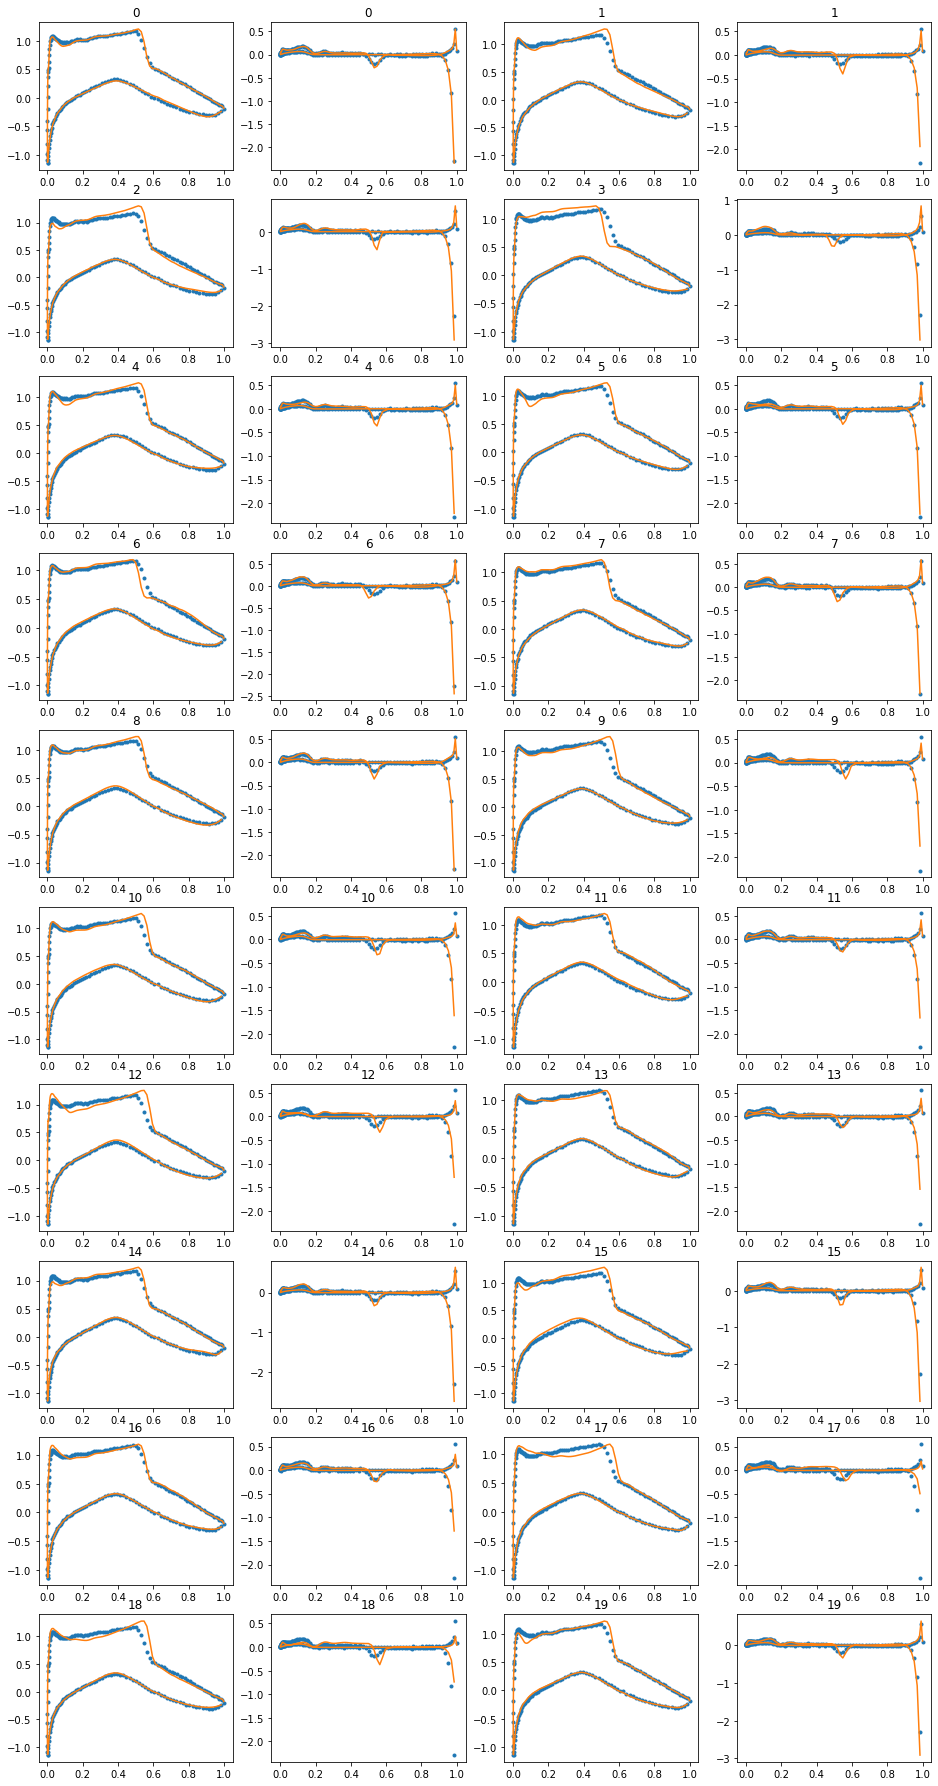

In [48]:
net.eval()

for inputs, target in loader_test:
    #outputs = net(inputs)
    h0 = net.init_hidden()
    outputs, _ = net(inputs, h0)
    loss = criterion(outputs, target)
    print(loss.detach())
    break

fig, axes = plt.subplots(10, 4, figsize=(16,32))

for k, ax in enumerate(axes.flat):
    i = int(k / 2)
    j = k % 2
    ax.plot(inputs[i,10:-10,0], -outputs[i][:,j].detach(), ".")
    ax.plot(inputs[i,10:-10,0], -target[i][:,j])
    ax.set_title(f"{i}")

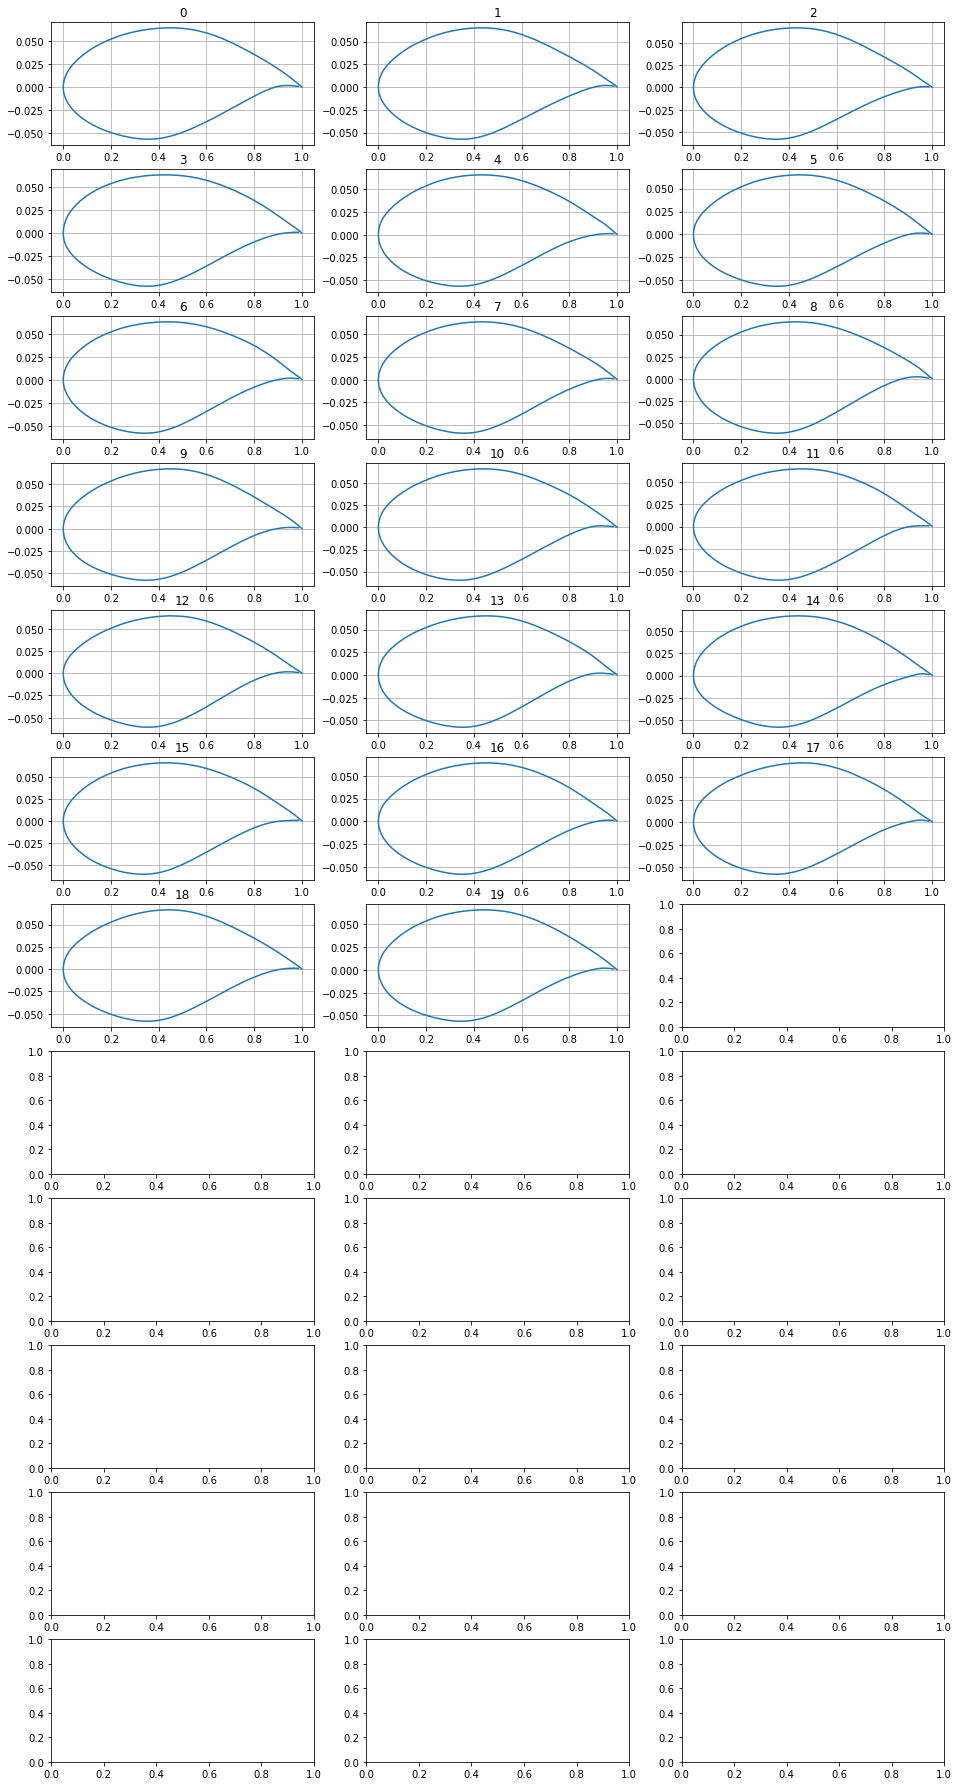

In [895]:
#for inputs, target in loader:
    #outputs = net(inputs)
#    break

fig, axes = plt.subplots(12,3, figsize=(16,32))
for i, ax in enumerate(axes.flat[:inputs.shape[0]]):
    ax.plot(x_vals, inputs[i][10:-10, 1], "-")
    ax.set_title(f"{i}")
    ax.grid(True, "both")

In [893]:
inputs[i][10:-10,1]

tensor([ 0.0009,  0.0014,  0.0017,  0.0019,  0.0016,  0.0008, -0.0005, -0.0022,
        -0.0043, -0.0066, -0.0090, -0.0115, -0.0141, -0.0167, -0.0193, -0.0219,
        -0.0244, -0.0270, -0.0294, -0.0319, -0.0343, -0.0366, -0.0388, -0.0410,
        -0.0430, -0.0451, -0.0470, -0.0487, -0.0504, -0.0519, -0.0532, -0.0543,
        -0.0552, -0.0559, -0.0562, -0.0564, -0.0563, -0.0561, -0.0556, -0.0550,
        -0.0544, -0.0536, -0.0528, -0.0519, -0.0509, -0.0499, -0.0488, -0.0478,
        -0.0466, -0.0455, -0.0443, -0.0431, -0.0419, -0.0407, -0.0394, -0.0381,
        -0.0368, -0.0355, -0.0342, -0.0329, -0.0315, -0.0302, -0.0289, -0.0275,
        -0.0262, -0.0248, -0.0234, -0.0221, -0.0207, -0.0193, -0.0180, -0.0166,
        -0.0152, -0.0139, -0.0125, -0.0111, -0.0097, -0.0084, -0.0070, -0.0056,
        -0.0042, -0.0028, -0.0014,  0.0000,  0.0011,  0.0023,  0.0034,  0.0045,
         0.0056,  0.0067,  0.0078,  0.0090,  0.0101,  0.0112,  0.0123,  0.0134,
         0.0145,  0.0156,  0.0167,  0.01

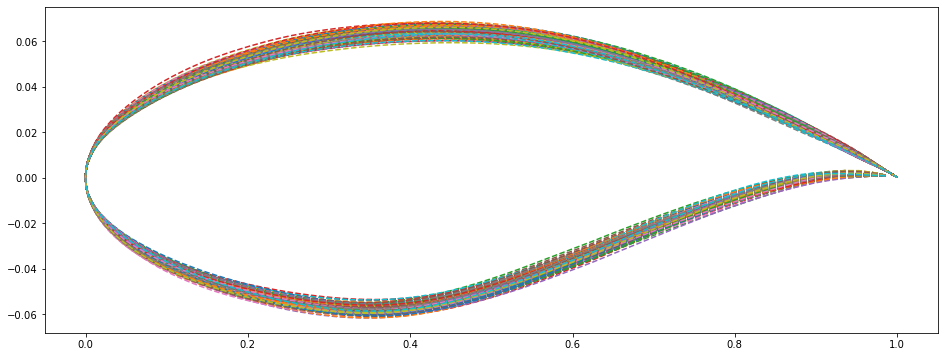

In [607]:
fig, ax = plt.subplots(1, figsize=(16,6))
for i in range(360):
    ax.plot(x_vals, X[i][1][10:-10], "--")

(<Figure size 432x288 with 4 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

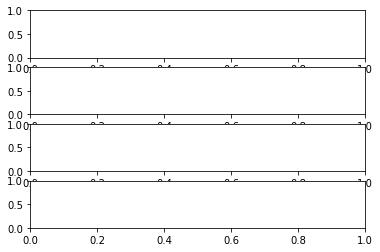

In [543]:
plt.subplots(4)

In [384]:
ax.plot(outputs[0][0].detach())

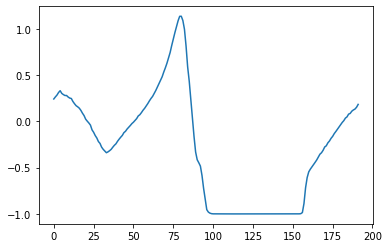

In [385]:
fig

In [394]:
df_surface_flow_total[df_surface_flow_total["PointID"]==25]

,Unnamed: 0,PointID,x,y,Density,Momentum_x,Momentum_y,Energy,Nu_Tilde,Pressure,Temperature,Mach,Pressure_Coefficient,Laminar_Viscosity,Skin_Friction_Coefficient_x,Skin_Friction_Coefficient_y,Heat_Flux,Y_Plus,Eddy_Viscosity,DIR
0,0,25,0.985397,0.000803,0.463907,0.0,0.0,105496.521933,0.0,42198.608773,316.882062,0.0,0.237030,0.000019,0.002553,-0.000058,-324.889895,2.405696,0.0,DSN_052
192,0,25,0.985397,0.001057,0.466478,0.0,0.0,106116.991203,0.0,42446.796481,316.988879,0.0,0.254234,0.000019,0.002505,-0.000152,-299.899442,2.394823,0.0,DSN_276
384,0,25,0.985397,0.000966,0.466992,0.0,0.0,106236.457152,0.0,42494.582861,316.996666,0.0,0.257546,0.000019,0.002453,-0.000110,-280.647847,2.368133,0.0,DSN_022
576,0,25,0.985397,0.001066,0.465645,0.0,0.0,105919.021325,0.0,42367.608530,316.963536,0.0,0.248745,0.000019,0.002534,-0.000153,-312.403121,2.406364,0.0,DSN_122
768,0,25,0.985397,0.000898,0.463247,0.0,0.0,105352.393799,0.0,42140.957520,316.899953,0.0,0.233033,0.000019,0.002610,-0.000101,-317.990880,2.432496,0.0,DSN_261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68160,0,25,0.985397,0.001065,0.466106,0.0,0.0,106031.376613,0.0,42412.550645,316.985941,0.0,0.251860,0.000019,0.002527,-0.000153,-309.660098,2.404289,0.0,DSN_138
68352,0,25,0.985397,0.001060,0.467916,0.0,0.0,106460.207388,0.0,42584.082955,317.036913,0.0,0.263750,0.000019,0.002445,-0.000144,-283.451420,2.368810,0.0,DSN_301
68544,0,25,0.985397,0.000818,0.461999,0.0,0.0,105071.073250,0.0,42028.429300,316.907463,0.0,0.225233,0.000019,0.002610,-0.000071,-318.935668,2.427716,0.0,DSN_336
68736,0,25,0.985397,0.000883,0.465976,0.0,0.0,106000.284062,0.0,42400.113625,316.981462,0.0,0.250998,0.000019,0.002481,-0.000082,-282.214791,2.377468,0.0,DSN_048


In [397]:
x_vals = df_surface_flow["x"].values

In [667]:
soboleng = torch.quasirandom.SobolEngine(dimension=38, scramble=True)
draws = 0.001*(soboleng.draw(1)-0.5)

In [669]:
draws.flatten().numpy()

array([ 2.3202015e-04,  4.6774265e-04,  1.6499490e-04, -1.5811292e-04,
       -2.7199800e-04,  3.5873117e-04, -2.4326281e-04,  2.8838386e-04,
       -1.7917917e-04,  3.0266008e-04,  4.4834384e-04,  9.3524402e-05,
        1.0176957e-05, -1.4537157e-04, -1.4585478e-04, -5.5356893e-05,
       -4.3590067e-04,  1.9843972e-04, -2.4472372e-04,  4.6195742e-04,
        2.9589343e-04, -2.7599843e-05, -1.5216968e-04,  3.7437621e-05,
        2.6636341e-04,  1.2455905e-04,  9.7863260e-05,  2.9542955e-04,
       -3.0887898e-04,  3.6889882e-04,  3.3480962e-04,  2.2457590e-04,
        2.6678434e-04,  1.3783909e-04, -2.0291639e-04, -1.3858835e-04,
        3.4718504e-04,  3.1562831e-04], dtype=float32)

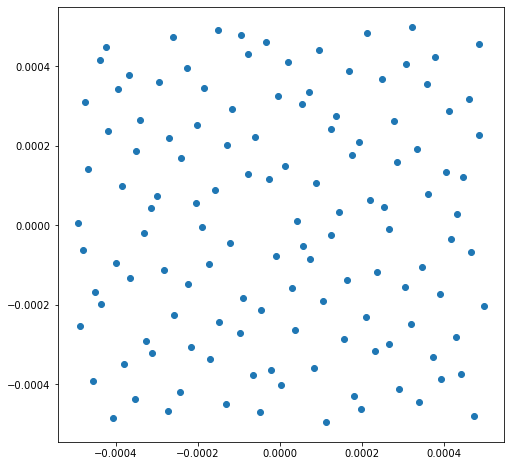

In [663]:
plt.figure(figsize=(8,8))
plt.scatter(draws[:,0], draws[:,1])

In [666]:
draws.numpy()

array([[ 2.8960480e-04, -4.1230911e-04,  3.6377157e-04, ...,
         1.9312931e-04, -1.2438605e-04, -1.1168063e-04],
       [ 1.8524290e-05,  4.1015580e-04,  1.9762279e-05, ...,
        -3.9270642e-05, -2.5974543e-04, -4.4185063e-04],
       [-3.3043462e-04, -1.7965229e-05, -4.2232755e-04, ...,
         4.1220296e-04,  4.5899674e-04,  4.1525939e-04],
       ...,
       [ 2.8588474e-04,  1.6047193e-04, -1.9795273e-04, ...,
        -2.3675442e-04, -4.6535651e-04,  2.4890507e-04],
       [-9.7761396e-05, -2.7127232e-04,  3.5839155e-04, ...,
         3.7134465e-04,  2.5341756e-04, -1.4421580e-04],
       [-9.4933035e-05,  4.7895042e-04,  5.6172314e-05, ...,
         4.8373613e-04,  3.8183422e-04, -1.2943501e-04]], dtype=float32)

In [675]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
src = torch.rand(10, 32, 512)
out = encoder_layer(src)

In [676]:
out.shape

torch.Size([10, 32, 512])